# Финальный проект. Предсказание температуры сплава.

## Цель проекта
Разработать модель для предсказания температуры сплава с целью сокращения энергопотребления и оптимизации расходов предприятия.  

Металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Позставлена задача — построить модель, которая сможет предсказывать финальную температуру сплава, используя технические параметры по обработке партии стали.  Заказчик планирует использовать разработанную модель для имитации технологического процесса.  
Метрика качества - MAE, целевое значение 6.8 и менее на тестовой выборке.  

Таргет - финальная температура сплава.  
Дополнительные условия заказчика:
* соотношение трейн:тест - 3:1
* из тестовой выборки не удалять выбросы
* итоговую модель проверить на адекватность сравнением с константной моделью

## Описание данных  
Файлы:  
data_arc_new.csv — данные об электродах;  
data_bulk_new.csv — данные о подаче сыпучих материалов (объём);  
data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);  
data_gas_new.csv — данные о продувке сплава газом;  
data_temp_new.csv — результаты измерения температуры;  
data_wire_new.csv — данные о проволочных материалах (объём);  
data_wire_time_new.csv — данные о проволочных материалах (время).  


Файл data_arc_new.csv  
key — номер партии;  
Начало нагрева дугой — время начала нагрева;  
Конец нагрева дугой — время окончания нагрева;  
Активная мощность — значение активной мощности;  
Реактивная мощность — значение реактивной мощности.  


Файл data_bulk_new.csv  
key — номер партии;  
Bulk 1 … Bulk 15 — объём подаваемого материала.  


Файл data_bulk_time_new.csv  
key — номер партии;  
Bulk 1 … Bulk 15 — время подачи материала.  


Файл data_gas_new.csv  
key — номер партии;  
Газ 1 — объём подаваемого газа.  


Файл data_temp_new.csv  
Скачать файл  
key — номер партии;  
Время замера — время замера;  
Температура — значение температуры.  


Файл data_wire_new.csv  
key — номер партии;  
Wire 1 … Wire 9 — объём подаваемых проволочных материалов.  


Файл data_wire_time_new.csv  
key — номер партии;  
Wire 1 … Wire 9 — время подачи проволочных материалов.

## План работы
1. Загрузка и первичный обзор данных
2. Исследовательский анализ и предобработка данных
3. Объединение данных
4. Исследовательский анализ и предобработка данных объединённого датафрейма
5. Подготовка данных
6. Обучение моделей 
7. Выбор лучшей модели
8. Общий вывод и рекомендации заказчику

## Технический блок кода

In [28]:
# Импорты
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error


### Собственные функции

In [29]:
def data_load_review(file_name):
    """ Функция для загрузи и первичного обзора данных (адаптирована для текущего проекта).
    Args:
        file_name - имя файла
    Returns:
        df - загруженный датасет.
        Функция выводит следующие сведения:
        Название датасета
        Кол-во строк
        Кол-во столбцов
        Кол-во явных дубликатов
        Количество уникальных партий (параметр 'key')
        Пример датасета
        Таблицу с данными по каждому столбцу (тип данных, уникальных значений, кол-во пропусков, долю пропусков)
    """
    try:
        # загрузка данных
        df = pd.read_csv('data/' + file_name,
                            sep=',',
                            decimal='.',
                            parse_dates=True)

        # Отображение общей информации
        res_dupl = df.duplicated().sum()
        print('Датасет:', file_name,
              '\nСтрок:', df.shape[0],
              '\nСтолбцов:', df.shape[1],
              '\nКоличество явных дубликатов:', res_dupl,
              '\nУникальных партий (по полю \'key\'):', df.key.nunique(),
              '\n\nПример датасета:')
        display(df.sample(5))

        # Обзорная информация о датасете
        print('Обзорная информация о датасете:')
        res = pd.DataFrame(columns=['Имя столбца','Тип данных','Уникальных значений','Число пропусков','Доля пропусков'])
        k=0
        for i in df.columns:
            k +=1
            res.loc[k] = [i,
                        df.dtypes[i],
                        len(df[i].unique()),
                        df[i].isna().sum(),
                        round(df[i].isna().mean() * 100, 3)
                        ]
        display(res)
        return df
    except:
        print('Ошибка загрузки датасета ', file_name)

In [30]:
def research_data_analysis_plots (dataframe, bins=40, include_col=[], except_col=[]):
    """ Функция рисует графики
        в данной версии обрабатывает только типы числовые и object/bool.
    Args
        data(DataFrame) - датафрейм с данными
        bins(int)=40 - кол-во корзин гистограммы
        include_col([str]) - список столбцов, требующих визуализации
        except_col([str]) - список столбцов, не требующих визуализации
                        (принимается во внимание, если include_col == [])
    Returns
        нет возвращаемых значений
    """
    # список всех колонок датафрейма для обработки
    if include_col == []:
        total_list_col = set(dataframe.columns) - set(except_col)
    else:
        total_list_col = include_col

    # формирование списка числовых и категориальных переменных датафрейма
    num_types_list = ['int_', 'int8', 'int16', 'int32', 'int64', 'uint8', 'uint16', 'uint32', 'uint64',
                     'float_', 'float16', 'float32', 'float64']
    cat_types_list = ['object','bool']
    num_list=[]
    cat_list = []
    for i in total_list_col:
        if dataframe.dtypes[i] in num_types_list:
            num_list.append(i)
        elif dataframe.dtypes[i] in cat_types_list:
            cat_list.append(i)
        else:
            print(i,' - другие типы. Доработать функцию!')

    # сброс индекса в датафрейме для boxplot
    dataframe_ri = pd.DataFrame()
    dataframe_ri = dataframe.reset_index(drop=True)

    # Отрисовка графиков числовых переменных
    if len(num_list) > 0:
        if len(num_list) <= 3:
            rows = 2
            cols = len(num_list)
            fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*5, rows*4))
        else:
            rows = math.ceil(len(num_list) / 3) * 2
            cols = 3
            fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,rows*4))

        row_count = 0  # счетчик для рядов графиков
        col_count = 0  # счетчик для колонок графиков

        # общий заголовок
        fig.suptitle('Обзор данных: количеcтвенные признаки',
                     y=(0.95-rows/200),
                     size='x-large')
        # расстояние между графиками по ширине и высоте
        fig.subplots_adjust(wspace=0.3, hspace=0.4)

        for i in num_list:
            if cols == 1:
                sns.histplot(data=dataframe[i], bins=bins, ax=axes[row_count], kde=False).set_title(i)
                sns.boxplot(data=dataframe_ri[i], orient='h', ax=axes[row_count+1])
            else:
                sns.histplot(data=dataframe[i], bins=bins, ax=axes[row_count, col_count], kde=False).set_title(i)
                sns.boxplot(data=dataframe_ri[i], orient='h', ax=axes[row_count+1, col_count])

            col_count += 1
            if col_count > 2:
                row_count += 2
                col_count = 0

            # удаляем пустые графики
            if i == num_list[-1] and col_count != 0 and rows > 2:
                for j in range(col_count, 3):
                    fig.delaxes(axes[row_count][j])
                    fig.delaxes(axes[row_count+1][j])
        plt.show

    # Отрисовка графиков категориальных переменных
    if len(cat_list) > 0:
        rows = math.ceil(len(cat_list) / 3)
        if rows > 1:
            fig, axes = plt.subplots(nrows=rows, ncols=3, figsize=(15,rows*4))
            row_count = 0 # счетчик для рядов графиков
            col_count = 0 # счетчик для колонок графиков
            plt.suptitle('Обзор данных: категориальные признаки')
            for i in cat_list:
                data_x = dataframe.groupby(i)[i].count().index
                data_y = dataframe.groupby(i)[i].count().values
                sns.barplot(y=data_x, x=data_y, orient='h', ax=axes[row_count, col_count])
                col_count += 1
                if col_count > 2:
                    row_count += 1
                    col_count = 0
                plt.subplots_adjust(wspace=0.5) # расстояние между графикам по ширине

                # удаляем пустые графики
                if i == cat_list[-1] and col_count != 0:
                    for j in range(col_count,3):
                        fig.delaxes(axes[row_count][j])

        elif rows == 1:
            fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
            plt.suptitle('Обзор данных: категориальные признаки', y=0.8)
            col_count = 0 # счетчик для колонок графиков
            for i in cat_list:
                data_x = dataframe.groupby(i)[i].count().index
                data_y = dataframe.groupby(i)[i].count().values
                sns.barplot(x=data_x, y=data_y, orient='v', ax=axes[col_count])
                col_count += 1

                # удаляем пустые графики
                if i == cat_list[-1] and col_count <= 3:
                    for j in range(col_count,3):
                        fig.delaxes(axes[0][j])

### Константны

In [31]:
RANDOM_STATE = 220724

## Загрузка и первичный обзор данных

In [32]:
df_arc = data_load_review('data_arc_new.csv')

Датасет: data_arc_new.csv 
Строк: 14876 
Столбцов: 5 
Количество явных дубликатов: 0 
Уникальных партий (по полю 'key'): 3214 

Пример датасета:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
354,76,2019-05-06 07:51:50,2019-05-06 07:53:49,0.478879,0.351522
3234,700,2019-05-30 19:17:10,2019-05-30 19:21:33,0.865617,0.534449
2216,475,2019-05-21 17:18:35,2019-05-21 17:20:24,0.464453,0.417134
6619,1440,2019-06-26 12:53:34,2019-06-26 12:55:34,0.597854,0.445317
6842,1487,2019-06-28 09:09:17,2019-06-28 09:11:28,0.558606,0.379898


Обзорная информация о датасете:


,Имя столбца,Тип данных,Уникальных значений,Число пропусков,Доля пропусков
1,key,int64,3214,0,0.0
2,Начало нагрева дугой,object,14876,0,0.0
3,Конец нагрева дугой,object,14876,0,0.0
4,Активная мощность,float64,13846,0,0.0
5,Реактивная мощность,float64,14707,0,0.0


In [33]:
df_bulk_volume = data_load_review('data_bulk_new.csv')

Датасет: data_bulk_new.csv 
Строк: 3129 
Столбцов: 16 
Количество явных дубликатов: 0 
Уникальных партий (по полю 'key'): 3129 

Пример датасета:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1001,1046,NaN,NaN,NaN,NaN,NaN,90.0,NaN,NaN,NaN,NaN,25.0,205.0,NaN,114.0,106.0
2038,2110,39.0,270.0,NaN,94.0,122.0,NaN,405.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
756,790,NaN,NaN,256.0,NaN,NaN,40.0,NaN,NaN,NaN,NaN,NaN,307.0,NaN,216.0,158.0
1470,1526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,72.0,NaN
2322,2406,NaN,NaN,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,263.0,NaN,176.0,160.0


Обзорная информация о датасете:


,Имя столбца,Тип данных,Уникальных значений,Число пропусков,Доля пропусков
1,key,int64,3129,0,0.000
2,Bulk 1,float64,48,2877,91.946
3,Bulk 2,float64,16,3107,99.297
4,Bulk 3,float64,279,1831,58.517
5,Bulk 4,float64,207,2115,67.593
6,Bulk 5,float64,56,3052,97.539
7,Bulk 6,float64,206,2553,81.592
8,Bulk 7,float64,26,3104,99.201
9,Bulk 8,float64,2,3128,99.968
10,Bulk 9,float64,11,3110,99.393


In [34]:
df_bulk_time = data_load_review('data_bulk_time_new.csv')

Датасет: data_bulk_time_new.csv 
Строк: 3129 
Столбцов: 16 
Количество явных дубликатов: 0 
Уникальных партий (по полю 'key'): 3129 

Пример датасета:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
906,945,NaN,NaN,2019-06-09 04:56:38,NaN,NaN,2019-06-09 05:57:53,NaN,NaN,NaN,NaN,NaN,2019-06-09 05:40:49,NaN,2019-06-09 05:35:15,2019-06-09 05:04:39
622,652,NaN,NaN,NaN,2019-05-28 22:07:44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-28 21:55:00,NaN,2019-05-28 21:49:57,2019-05-28 21:12:24
2026,2097,2019-07-26 22:47:29,NaN,2019-07-26 22:43:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-26 22:36:17,NaN,2019-07-26 21:56:32,2019-07-26 21:38:08
2248,2329,NaN,NaN,2019-08-04 06:29:21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-04 06:44:02,NaN,2019-08-04 06:44:02,2019-08-04 06:36:04
1106,1154,NaN,NaN,NaN,2019-06-16 10:27:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Обзорная информация о датасете:


,Имя столбца,Тип данных,Уникальных значений,Число пропусков,Доля пропусков
1,key,int64,3129,0,0.000
2,Bulk 1,object,253,2877,91.946
3,Bulk 2,object,23,3107,99.297
4,Bulk 3,object,1299,1831,58.517
5,Bulk 4,object,1015,2115,67.593
6,Bulk 5,object,78,3052,97.539
7,Bulk 6,object,577,2553,81.592
8,Bulk 7,object,26,3104,99.201
9,Bulk 8,object,2,3128,99.968
10,Bulk 9,object,20,3110,99.393


In [35]:
df_gas = data_load_review('data_gas_new.csv')

Датасет: data_gas_new.csv 
Строк: 3239 
Столбцов: 2 
Количество явных дубликатов: 0 
Уникальных партий (по полю 'key'): 3239 

Пример датасета:


,key,Газ 1
2319,2322,22.629002
16,17,15.175933
2175,2178,12.637810
376,379,12.759209
3027,3030,13.430490


Обзорная информация о датасете:


,Имя столбца,Тип данных,Уникальных значений,Число пропусков,Доля пропусков
1,key,int64,3239,0,0.0
2,Газ 1,float64,3239,0,0.0


In [36]:
df_temperature = data_load_review('data_temp_new.csv')

Датасет: data_temp_new.csv 
Строк: 18092 
Столбцов: 3 
Количество явных дубликатов: 0 
Уникальных партий (по полю 'key'): 3216 

Пример датасета:


,key,Время замера,Температура
8196,1466,2019-06-27 16:48:41,1587.0
17826,3189,2019-09-04 22:43:19,NaN
5386,956,2019-06-09 14:23:02,1583.0
17444,3120,2019-09-02 14:04:20,NaN
15270,2729,2019-08-18 21:47:36,NaN


Обзорная информация о датасете:


,Имя столбца,Тип данных,Уникальных значений,Число пропусков,Доля пропусков
1,key,int64,3216,0,0.000
2,Время замера,object,18092,0,0.000
3,Температура,float64,173,3427,18.942


In [37]:
df_wire_volume = data_load_review('data_wire_new.csv')

Датасет: data_wire_new.csv 
Строк: 3081 
Столбцов: 10 
Количество явных дубликатов: 0 
Уникальных партий (по полю 'key'): 3081 

Пример датасета:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1087,1154,107.218799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
161,177,116.276169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1680,1767,93.038399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1386,1458,70.012794,9.10832,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1030,1090,160.102799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Обзорная информация о датасете:


,Имя столбца,Тип данных,Уникальных значений,Число пропусков,Доля пропусков
1,key,int64,3081,0,0.000
2,Wire 1,float64,2252,26,0.844
3,Wire 2,float64,714,2002,64.979
4,Wire 3,float64,57,3018,97.955
5,Wire 4,float64,15,3067,99.546
6,Wire 5,float64,2,3080,99.968
7,Wire 6,float64,70,3008,97.631
8,Wire 7,float64,11,3070,99.643
9,Wire 8,float64,14,3062,99.383
10,Wire 9,float64,26,3052,99.059


In [38]:
df_wire_time = data_load_review('data_wire_time_new.csv')

Датасет: data_wire_time_new.csv 
Строк: 3081 
Столбцов: 10 
Количество явных дубликатов: 0 
Уникальных партий (по полю 'key'): 3081 

Пример датасета:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
2376,2503,2019-08-10 16:41:48,2019-08-10 16:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2064,2162,2019-07-29 16:07:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
720,768,2019-06-02 13:18:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1870,1961,2019-07-21 21:25:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
680,723,2019-05-31 16:19:23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Обзорная информация о датасете:


,Имя столбца,Тип данных,Уникальных значений,Число пропусков,Доля пропусков
1,key,int64,3081,0,0.000
2,Wire 1,object,3056,26,0.844
3,Wire 2,object,1080,2002,64.979
4,Wire 3,object,64,3018,97.955
5,Wire 4,object,15,3067,99.546
6,Wire 5,object,2,3080,99.968
7,Wire 6,object,74,3008,97.631
8,Wire 7,object,12,3070,99.643
9,Wire 8,object,20,3062,99.383
10,Wire 9,object,30,3052,99.059


По результатам первичного беглого изучения данных известно:
1. Загружено 7 датасетов.
2. Имеем данные о нагреве по 3214 уникальным партиям. Каждая партия прошла в среднем 4.6 итераций нагрева. Интревалы между итерациями неравномерные. Длительность включения электродов различная в каждой итерации.
3. Данные о добавлении сыпучих компонентов представлены для 3129 партий. Большая доля пропусков для многих компонентов.
4. Данные о добавлении проволочных компонентов представлены для 3081 партий. Большая доля пропусков для многих компонентов.
5. Информация о продувке газом представлена для 3239 уникальных партий. Для каждой партии указано одно значение объема использованного газа, данных о времени продувки нет.
6. Данные о температуре представлены для 3216 партий. Измерение в каждой партии происходит неоднократно, интервал измерений не фиксированный. Среднее число измерений температуры 5.6 на партию. В 18.9% измерений температура не указана.
7. Явные дубликаты во всех датасетах отсутствуют.

## Исследовательский анализ и предобработка данных

### Данные о включении электродов: df_electrodes

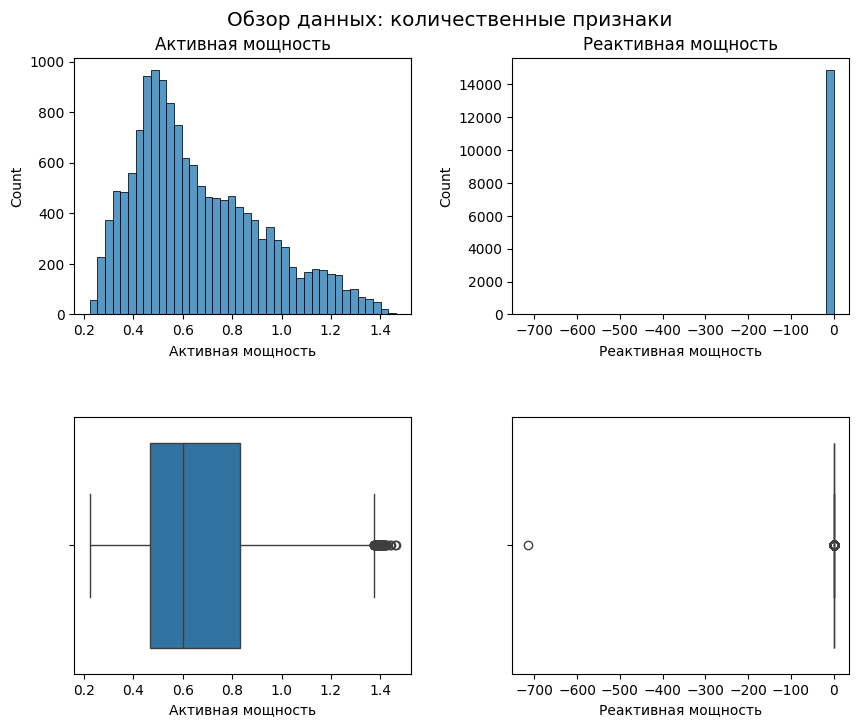

In [39]:
research_data_analysis_plots(df_arc, except_col=['Начало нагрева дугой', 'Конец нагрева дугой', 'key'])

In [40]:
# В колонке "Реактивная мощность" видим аномальное отрицательное значение.
ind_ = df_arc.loc[df_arc['Реактивная мощность'] < 0].index[0]
df_arc.loc[ind_]

key                                    2116
Начало нагрева дугой    2019-07-28 02:22:08
Конец нагрева дугой     2019-07-28 02:23:57
Активная мощность                  0.705344
Реактивная мощность             -715.479924
Name: 9780, dtype: object

In [41]:
# Реактивная мощность пропорциональна активной. Расчитаем соотношение этих показателей в данном датасете (без учета выброса).
mean_ap = df_arc.drop(index=ind_, axis=0)['Активная мощность'].mean()
mean_rp = df_arc.drop(index=ind_, axis=0)['Реактивная мощность'].mean()
proportion = mean_rp / mean_ap
print(proportion)

0.7349919390532254


In [42]:
# Заменим аномальное значение реактивной мощности расчетным на основании известной активной мощности
df_arc.loc[ind_, 'Реактивная мощность'] = df_arc.loc[ind_, 'Активная мощность'] * proportion
df_arc.loc[ind_]

key                                    2116
Начало нагрева дугой    2019-07-28 02:22:08
Конец нагрева дугой     2019-07-28 02:23:57
Активная мощность                  0.705344
Реактивная мощность                0.518422
Name: 9780, dtype: object

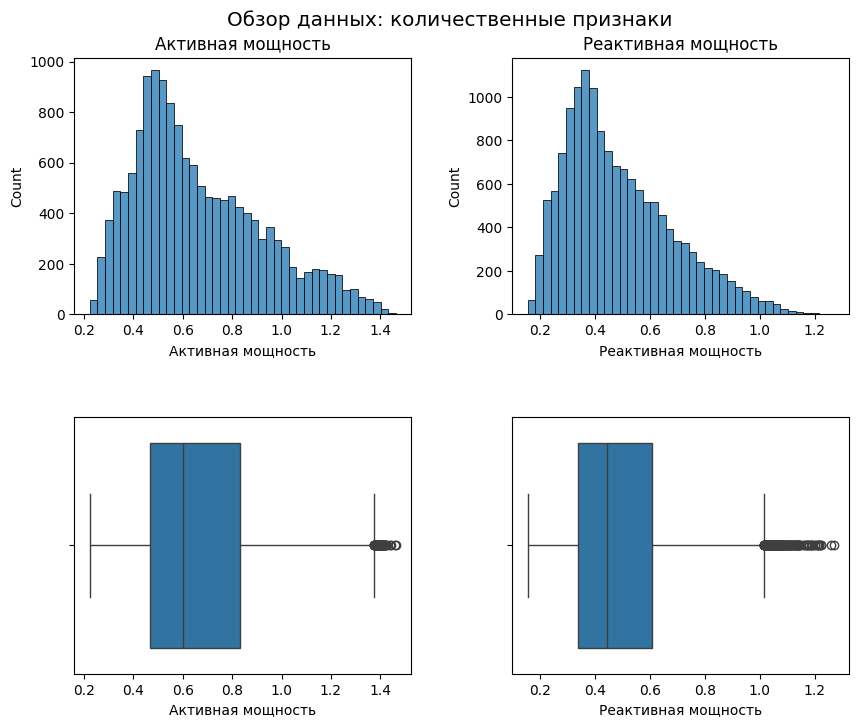

In [43]:
research_data_analysis_plots(df_arc, except_col=['Начало нагрева дугой', 'Конец нагрева дугой', 'key'])

In [44]:
# Обработаем параметры даты
df_arc['Конец нагрева дугой'] = df_arc['Конец нагрева дугой'].astype('datetime64[ns]')
df_arc['Начало нагрева дугой'] = df_arc['Начало нагрева дугой'].astype('datetime64[ns]')

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,heat_dur
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172


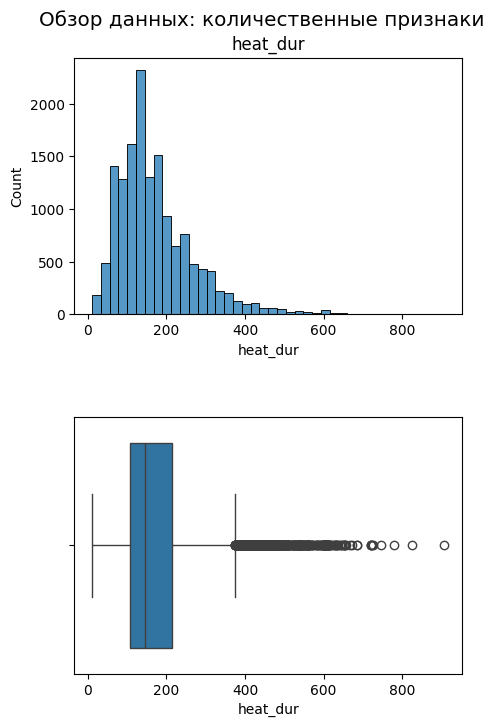

In [45]:
# Добавим новый признак - длительность итерации нагрева в секундах
df_arc['heat_dur'] = (df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой']).dt.seconds
display(df_arc.head(3))
research_data_analysis_plots(df_arc, include_col=['heat_dur'])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,heat_dur,iter_num
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228,5
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185,5
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172,5
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365,5
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148,5
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,137,4
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,338,4
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,126,4
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,210,4
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,280,5


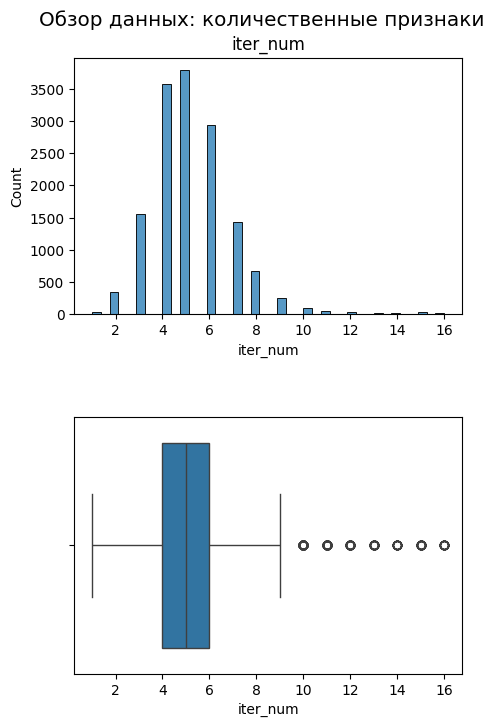

In [46]:
# Добавим новый признак - количество итераций нагрева для каждой партии
df_arc['iter_num'] = df_arc.groupby('key')['key'].transform('count')
display(df_arc.head(10))
research_data_analysis_plots(df_arc, include_col=['iter_num'])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,heat_dur,iter_num,batch_dur
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228,5,1583
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185,5,1583
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172,5,1583
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365,5,1583
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148,5,1583
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,137,4,1144
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,338,4,1144
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,126,4,1144
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,210,4,1144
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,280,5,1525


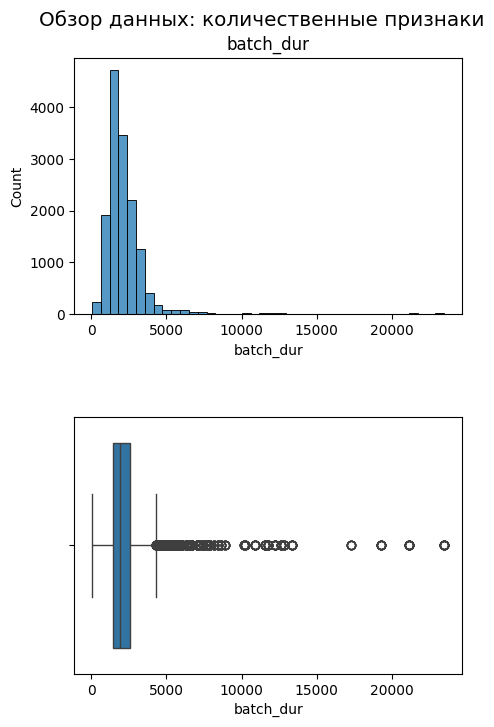

In [47]:
# Добавим новый признак - время обработки одной партии (от начала первого нагрева до окончания последнего нагрева) в секнундах
df_arc['batch_start'] = df_arc.groupby('key')['Начало нагрева дугой'].transform('first')
df_arc['batch_finish'] = df_arc.groupby('key')['Конец нагрева дугой'].transform('last')
df_arc['batch_dur'] = (df_arc.batch_finish - df_arc.batch_start).dt.seconds
df_arc.drop(columns=['batch_start', 'batch_finish'], inplace=True)
display(df_arc.head(10))
research_data_analysis_plots(df_arc, include_col=['batch_dur'])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,heat_dur,iter_num,batch_dur,total_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228,5,1583,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185,5,1583,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172,5,1583,0.722536


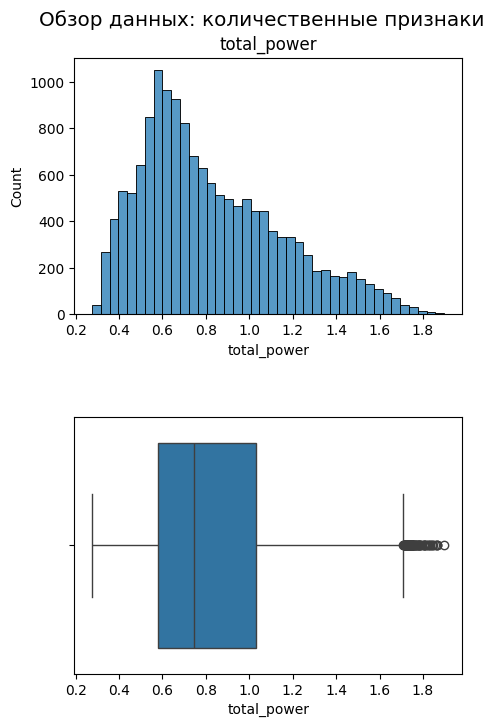

In [48]:
# Добавим новый признак - полная мощность. Формула расчета: https://www.asutpp.ru/reaktivnaya-moschnost.html
df_arc['total_power'] = (df_arc['Активная мощность'] ** 2 + df_arc['Реактивная мощность'] ** 2) ** 0.5
display(df_arc.head(3))
research_data_analysis_plots(df_arc, include_col=['total_power'])

In [49]:
# Добавим новый признак - расход электроэнергии. Расчитывается как произведения мощности и времени включения.
df_arc['power_consump'] = df_arc.total_power * df_arc.heat_dur
df_arc.head(3)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,heat_dur,iter_num,batch_dur,total_power,power_consump
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228,5,1583,0.371123,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185,5,1583,0.902319,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172,5,1583,0.722536,124.276277


In [50]:
df_arc.describe()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,heat_dur,iter_num,batch_dur,total_power,power_consump
count,14876.000000,14876,14876,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000
mean,1615.220422,2019-07-05 12:25:51.921081088,2019-07-05 12:28:43.592027392,0.662752,0.487118,171.670946,5.187416,2232.911670,0.823388,141.643891
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,0.153777,11.000000,1.000000,57.000000,0.275718,6.409531
25%,806.000000,2019-06-03 23:18:23.249999872,2019-06-03 23:21:35,0.467115,0.337192,107.000000,4.000000,1433.000000,0.578847,71.158372
50%,1617.000000,2019-07-03 01:31:26.500000,2019-07-03 01:35:13,0.599587,0.441667,147.000000,5.000000,1899.000000,0.746591,114.462623
75%,2429.000000,2019-08-07 22:52:20.750000128,2019-08-07 22:56:47,0.830070,0.608201,214.000000,6.000000,2583.000000,1.030390,181.345716
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284,907.000000,16.000000,23485.000000,1.898158,1084.729420
std,934.571502,NaN,NaN,0.258885,0.197606,98.186803,1.749516,1683.324262,0.323459,103.197604


Выводы по датафрейму df_arc:
1. Обработаны аномалии
2. Добавлены новые признаки - длительность нагрева в секундах, количество итераций нагрева, общая мощность, длительность обработки одной партии, расход электроэнергии.
3. Количество итераций нагрева от 1 до 16 на партию, в среднем 4.6 итераций.
4. Средняя продолжительность работы электродов 171 сек, средняя активная мощность при этом 0.66, реактивная мощность в среднем 0.48, полная - 0.82.

### Данные об объеме сыпучих материалов: df_bulk_volume

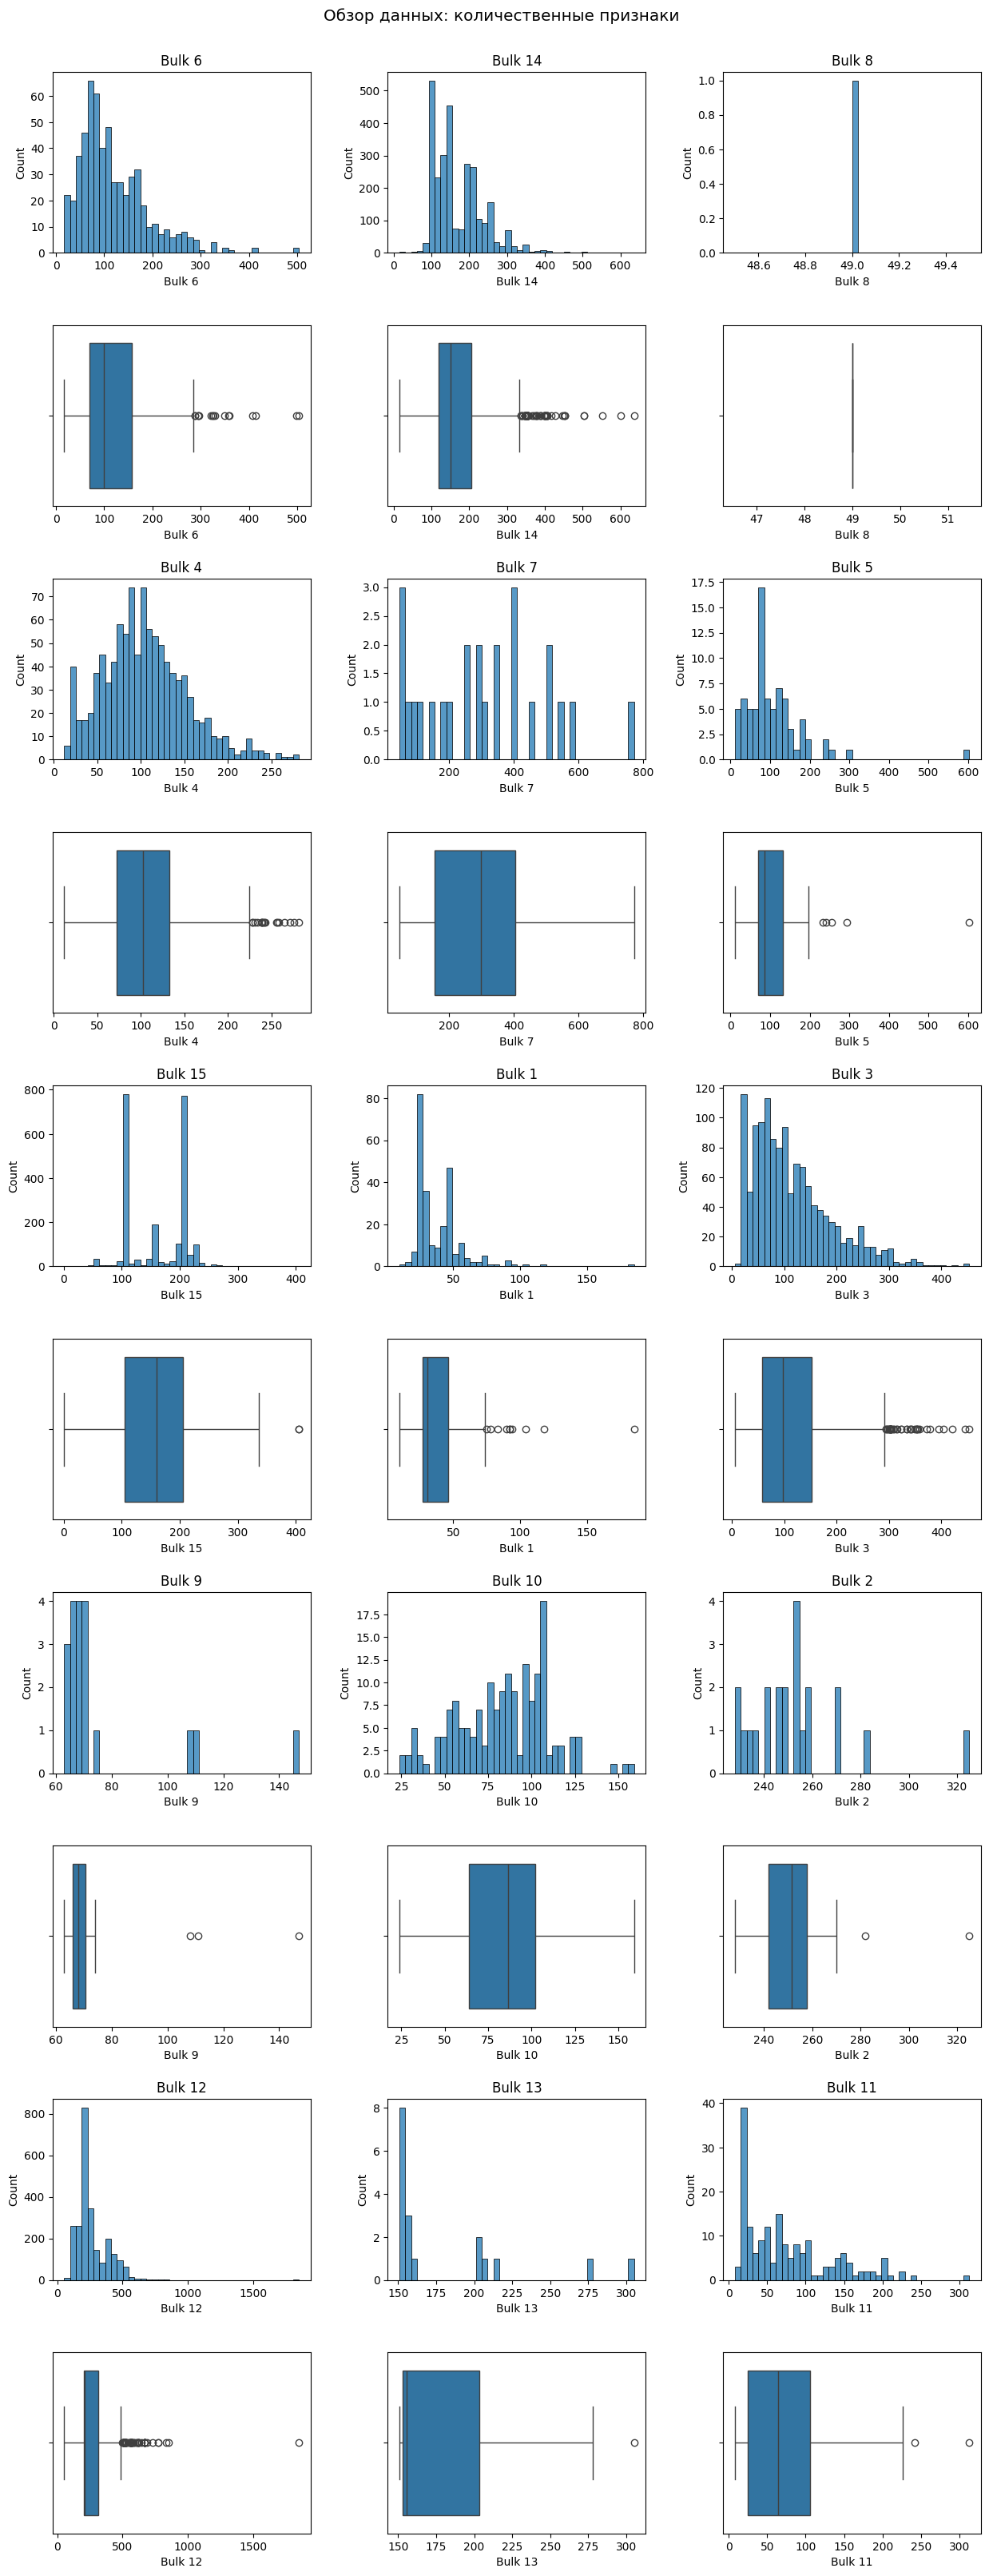

In [51]:
research_data_analysis_plots(df_bulk_volume, except_col=['key'])

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,total_bulk_vol
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,553.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,582.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,544.0


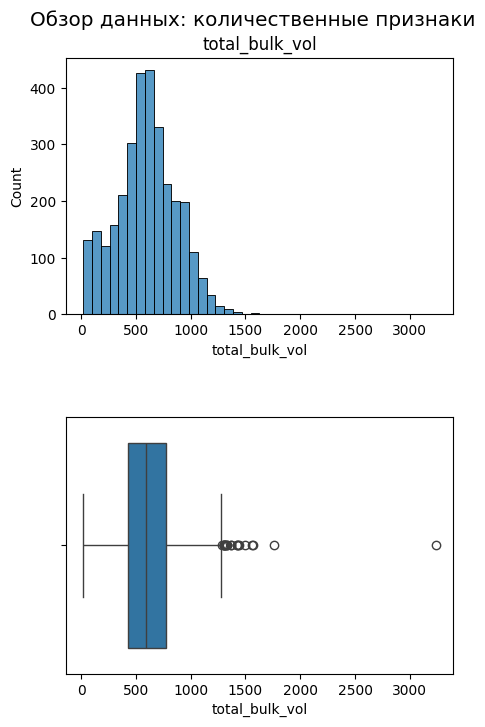

In [52]:
# Добавим новый параметр - общий объем сыпучих материалов
df_bulk_volume['total_bulk_vol'] = df_bulk_volume.loc[:,'Bulk 1':'Bulk 15'].sum(axis=1)
display(df_bulk_volume.head(3))
research_data_analysis_plots(df_bulk_volume, include_col=['total_bulk_vol'])

In [53]:
# Имеем статистические выброс. Обработка после резделение на тест и трейн.
df_bulk_volume[df_bulk_volume.total_bulk_vol > 3000]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,total_bulk_vol
303,322,185.0,NaN,101.0,58.0,NaN,NaN,406.0,NaN,NaN,NaN,NaN,1849.0,NaN,636.0,NaN,3235.0


In [54]:
# Проверим, есть ли повторяющиеся рецептуры по составу и объему добавок
df_bulk_volume.drop(columns='key').duplicated().sum()

np.int64(80)

In [55]:
# Посмотрим частоту применения каждой из сыпучих добавок
list_ = []
for i in df_bulk_volume.columns:
    list_.append(round((1-df_bulk_volume[i].isna().sum() / df_bulk_volume.shape[0]) * 100, 2))
df_ = pd.DataFrame(index=df_bulk_volume.columns, data=list_, columns=['share_of_use']).drop(index='key')
#df_['share_of_use'].astype('float')
df_


,share_of_use
Bulk 1,8.05
Bulk 2,0.70
Bulk 3,41.48
Bulk 4,32.41
Bulk 5,2.46
Bulk 6,18.41
Bulk 7,0.80
Bulk 8,0.03
Bulk 9,0.61
Bulk 10,5.62


In [56]:
# Объемы редко используемых добавок (менее 10% партий) удалим
df_bulk_volume.drop(columns=df_.query('share_of_use < 10').index, inplace=True)
df_bulk_volume.head(3)

,key,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,total_bulk_vol
0,1,NaN,43.0,NaN,206.0,150.0,154.0,553.0
1,2,NaN,73.0,NaN,206.0,149.0,154.0,582.0
2,3,NaN,34.0,NaN,205.0,152.0,153.0,544.0


In [57]:
# Заполним пропущенные значения нулями
df_bulk_volume.fillna(0, inplace=True)
df_bulk_volume.head(3)

,key,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,total_bulk_vol
0,1,0.0,43.0,0.0,206.0,150.0,154.0,553.0
1,2,0.0,73.0,0.0,206.0,149.0,154.0,582.0
2,3,0.0,34.0,0.0,205.0,152.0,153.0,544.0


In [58]:
df_bulk_volume.shape

(3129, 8)

Выводы по датафрейму df_bulk_volume:
1. Применяется 15 сыпучих материалов.
2. Некоторые добавки применяются в большинстве партий (например №12, 14, 15), некоторые - крайне редко (например №2, 7, 8, 9, 13).
3. Для большинства партий состав и объемы сыпучих материалов индивидуальны (повторяющиеся рецептуры найдены для 80 партий - это 2.5% от всех наблюдений)
4. Создан новый признак - общий объем сыпучих материалов
5. Удалены данные о редко используемых добавках (менее 10% партий)
6. Пропущенные значения заполнены нулями

### Данные о времени подачи сыпучих материалов: df_bulk_time

In [59]:
df_bulk_time.head(3)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16


In [60]:
print('Наблюдений в датасете:', df_bulk_time.shape[0],
      '\nУникальных партий:', df_bulk_time.key.nunique())

Наблюдений в датасете: 3129 
Уникальных партий: 3129


Выводы по датафрейму df_bulk_time:
1. Приведены данные о 15 сыпучих материалах.
2. Подача разных сыпучих материалов происходит неодновременно

### Данные о подаче газа: df_gas

In [61]:
df_gas.head(3)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793


In [62]:
print('Наблюдений в датасете:', df_gas.shape[0],
      '\nУникальных партий:', df_gas.key.nunique())

Наблюдений в датасете: 3239 
Уникальных партий: 3239


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


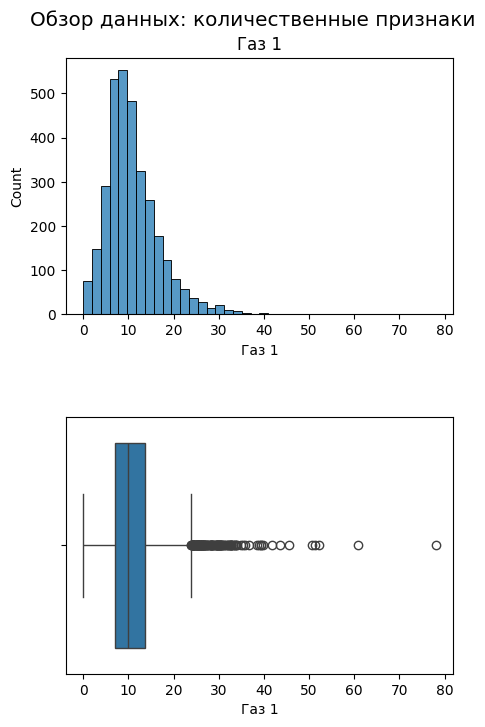

In [63]:
display(df_gas.describe())
research_data_analysis_plots(df_gas, include_col=['Газ 1'])

In [64]:
# Посмотрим на наблюдение с выбросом
df_gas[df_gas['Газ 1'] > 55]

,key,Газ 1
277,280,60.935689
319,322,77.995040


Выводы по датафрейму df_gas:
1. Имеются статистические выборосы (будут обработаны после разделения на тест и трейн)
2. Средний объем газа 11.0

### Данные о измерении температуры: df_temperature

In [65]:
df_temperature.head(3)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0


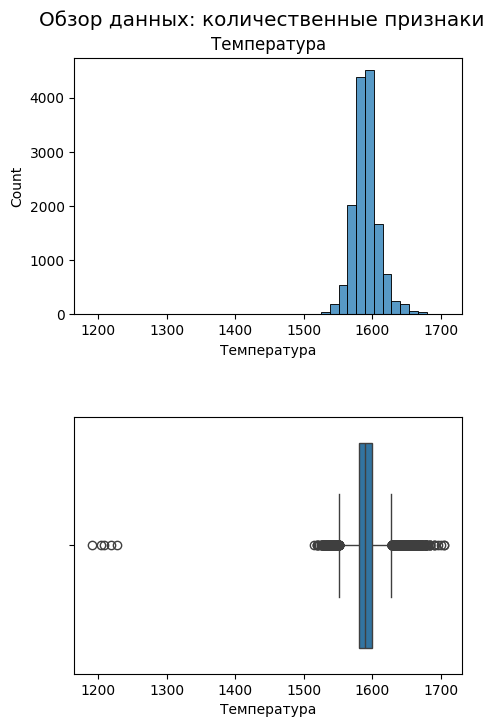

In [66]:
research_data_analysis_plots(df_temperature, include_col=['Температура'])

In [67]:
# Данные значения являются отклонениями от технологического процесса, удаляем аномалии.
df_temperature.loc[df_temperature['Температура'] < 1300]

,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


In [68]:
# Удалим записи по данным партиям
key_ = list(df_temperature.loc[df_temperature['Температура'] < 1300, 'key'].values)
df_temperature.drop(index=df_temperature.loc[df_temperature.key.isin(key_)].index, axis=0, inplace=True)
df_temperature.loc[df_temperature['Температура'] < 1300]

,key,Время замера,Температура


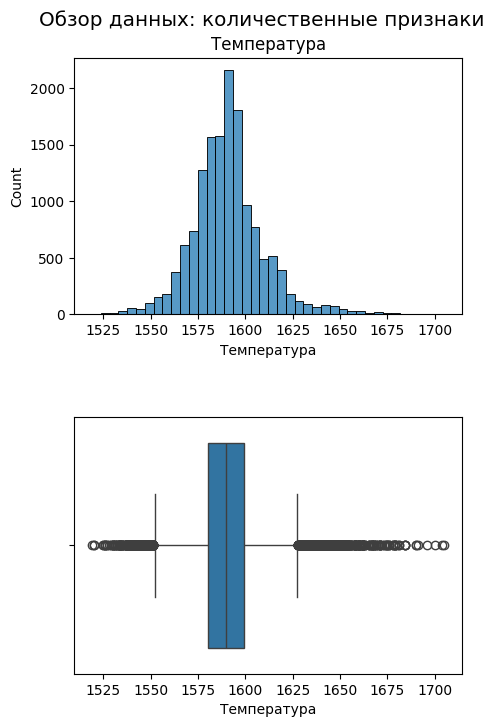

In [69]:
research_data_analysis_plots(df_temperature, include_col=['Температура'])

In [70]:
# Добавим два новых параметра - является ли измерение первым или финальным (1 - является, 0 - не является)
df_temperature['first'] = df_temperature.groupby('key')['Время замера'].transform('first')
df_temperature['first_measurement'] = (df_temperature['Время замера'] == df_temperature['first']).astype('int')

df_temperature['final'] = df_temperature.groupby('key')['Время замера'].transform('last')
df_temperature['final_measurement'] = (df_temperature['Время замера'] == df_temperature['final']).astype('int')

df_temperature.drop(columns=['first', 'final'], inplace=True)

df_temperature.head(10)

,key,Время замера,Температура,first_measurement,final_measurement
0,1,2019-05-03 11:02:04,1571.0,1,0
1,1,2019-05-03 11:07:18,1604.0,0,0
2,1,2019-05-03 11:11:34,1618.0,0,0
3,1,2019-05-03 11:18:04,1601.0,0,0
4,1,2019-05-03 11:25:59,1606.0,0,0
5,1,2019-05-03 11:30:38,1613.0,0,1
6,2,2019-05-03 11:34:04,1581.0,1,0
7,2,2019-05-03 11:38:40,1577.0,0,0
8,2,2019-05-03 11:46:09,1589.0,0,0
9,2,2019-05-03 11:49:38,1604.0,0,0


In [71]:
# Сопоставим количество измерений температуры и количество включний электродов
temp_ = pd.DataFrame(columns=['temp_count', 'electr_count'])
temp_.temp_count = df_temperature.groupby('key').agg({'Время замера':'count'})
temp_.electr_count = df_arc.groupby('key').agg({'Начало нагрева дугой':'count'})
temp_['difference'] = temp_.temp_count - temp_.electr_count
temp_.head(3)

,temp_count,electr_count,difference
key,,,
1,6,5.0,1.0
2,5,4.0,1.0
3,6,5.0,1.0


In [72]:
temp_.describe()

,temp_count,electr_count,difference
count,3211.000000,3209.000000,3209.0
mean,5.625973,4.628856,1.0
std,1.612045,1.608403,0.0
min,1.000000,1.000000,1.0
25%,5.000000,4.000000,1.0
50%,5.000000,4.000000,1.0
75%,7.000000,6.000000,1.0
max,17.000000,16.000000,1.0


In [73]:
# Оценим количество пропусков
print('Записей с пропущенным значением температуры: ', df_temperature['Температура'].isna().sum(),
      '\nПропуски имеются в уникальных партиях:', df_temperature.loc[df_temperature['Температура'].isna(), 'key'].nunique())

Записей с пропущенным значением температуры:  3422 
Пропуски имеются в уникальных партиях: 738


In [74]:
# Оценим количество пропусков финальной температуры (таргета)
key_ = list(df_temperature.loc[(df_temperature.final_measurement == 1) & (df_temperature['Температура'].isna()), 'key'].values)
print('Кол-во партий, с пропусками финальной температуры:', len(key_))
display(df_temperature.query('key in @key_').head(15))

Кол-во партий, с пропусками финальной температуры: 738


,key,Время замера,Температура,first_measurement,final_measurement
13926,2500,2019-08-10 14:04:39,1539.0,1,0
13927,2500,2019-08-10 14:13:11,NaN,0,0
13928,2500,2019-08-10 14:18:12,NaN,0,0
13929,2500,2019-08-10 14:25:53,NaN,0,0
13930,2500,2019-08-10 14:29:39,NaN,0,1
13931,2501,2019-08-10 14:41:14,1587.0,1,0
13932,2501,2019-08-10 14:49:15,NaN,0,0
13933,2501,2019-08-10 15:02:56,NaN,0,0
13934,2501,2019-08-10 15:07:47,NaN,0,0
13935,2501,2019-08-10 15:16:53,NaN,0,0


In [75]:
# Удаляем данные о партиях с пропусками финальной температуры
df_temperature.drop(index=df_temperature.loc[df_temperature.key.isin(key_)].index, axis=0, inplace=True)
df_temperature.loc[(df_temperature.final_measurement == 1) & (df_temperature['Температура'].isna()), 'key'].count()

np.int64(0)

In [76]:
# Проверим, есть ли партии только с одним измерением
df_ = df_temperature.groupby('key').agg({'Температура':'count'})
df_temperature.loc[df_temperature.key.isin(df_[df_['Температура'] < 2].index)]

,key,Время замера,Температура,first_measurement,final_measurement
1105,195,2019-05-11 00:01:36,1583.0,1,1
1549,279,2019-05-14 10:13:01,1603.0,1,1


In [77]:
# Удалим партии с единственным измерением
ind_ = df_temperature.loc[df_temperature.key.isin(df_[df_['Температура'] < 2].index)].index
df_temperature.drop(index=ind_, inplace=True)
df_temperature.loc[df_temperature.key.isin(df_[df_['Температура'] < 2].index)]

,key,Время замера,Температура,first_measurement,final_measurement


In [78]:
print('Уникальных партий после предобработки:', df_temperature.key.nunique())

Уникальных партий после предобработки: 2471


Выводы по датафрейму df_temperature:
1. Удалены аномальные значения.
2. Удалены данные партий с пропусками финальной температуры (таргета). Итого в датасете данные по 2471 партии.
3. Добавлены два параметра: является ли измерение первым для данной партии, а также, является ли измерение финальным
4. Количество замеров температуры равняется числу включения электродов + 1 (исходный замер)
 

### Данные о проволочных материалах: df_wire_volume

In [79]:
df_wire_volume.head(3)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


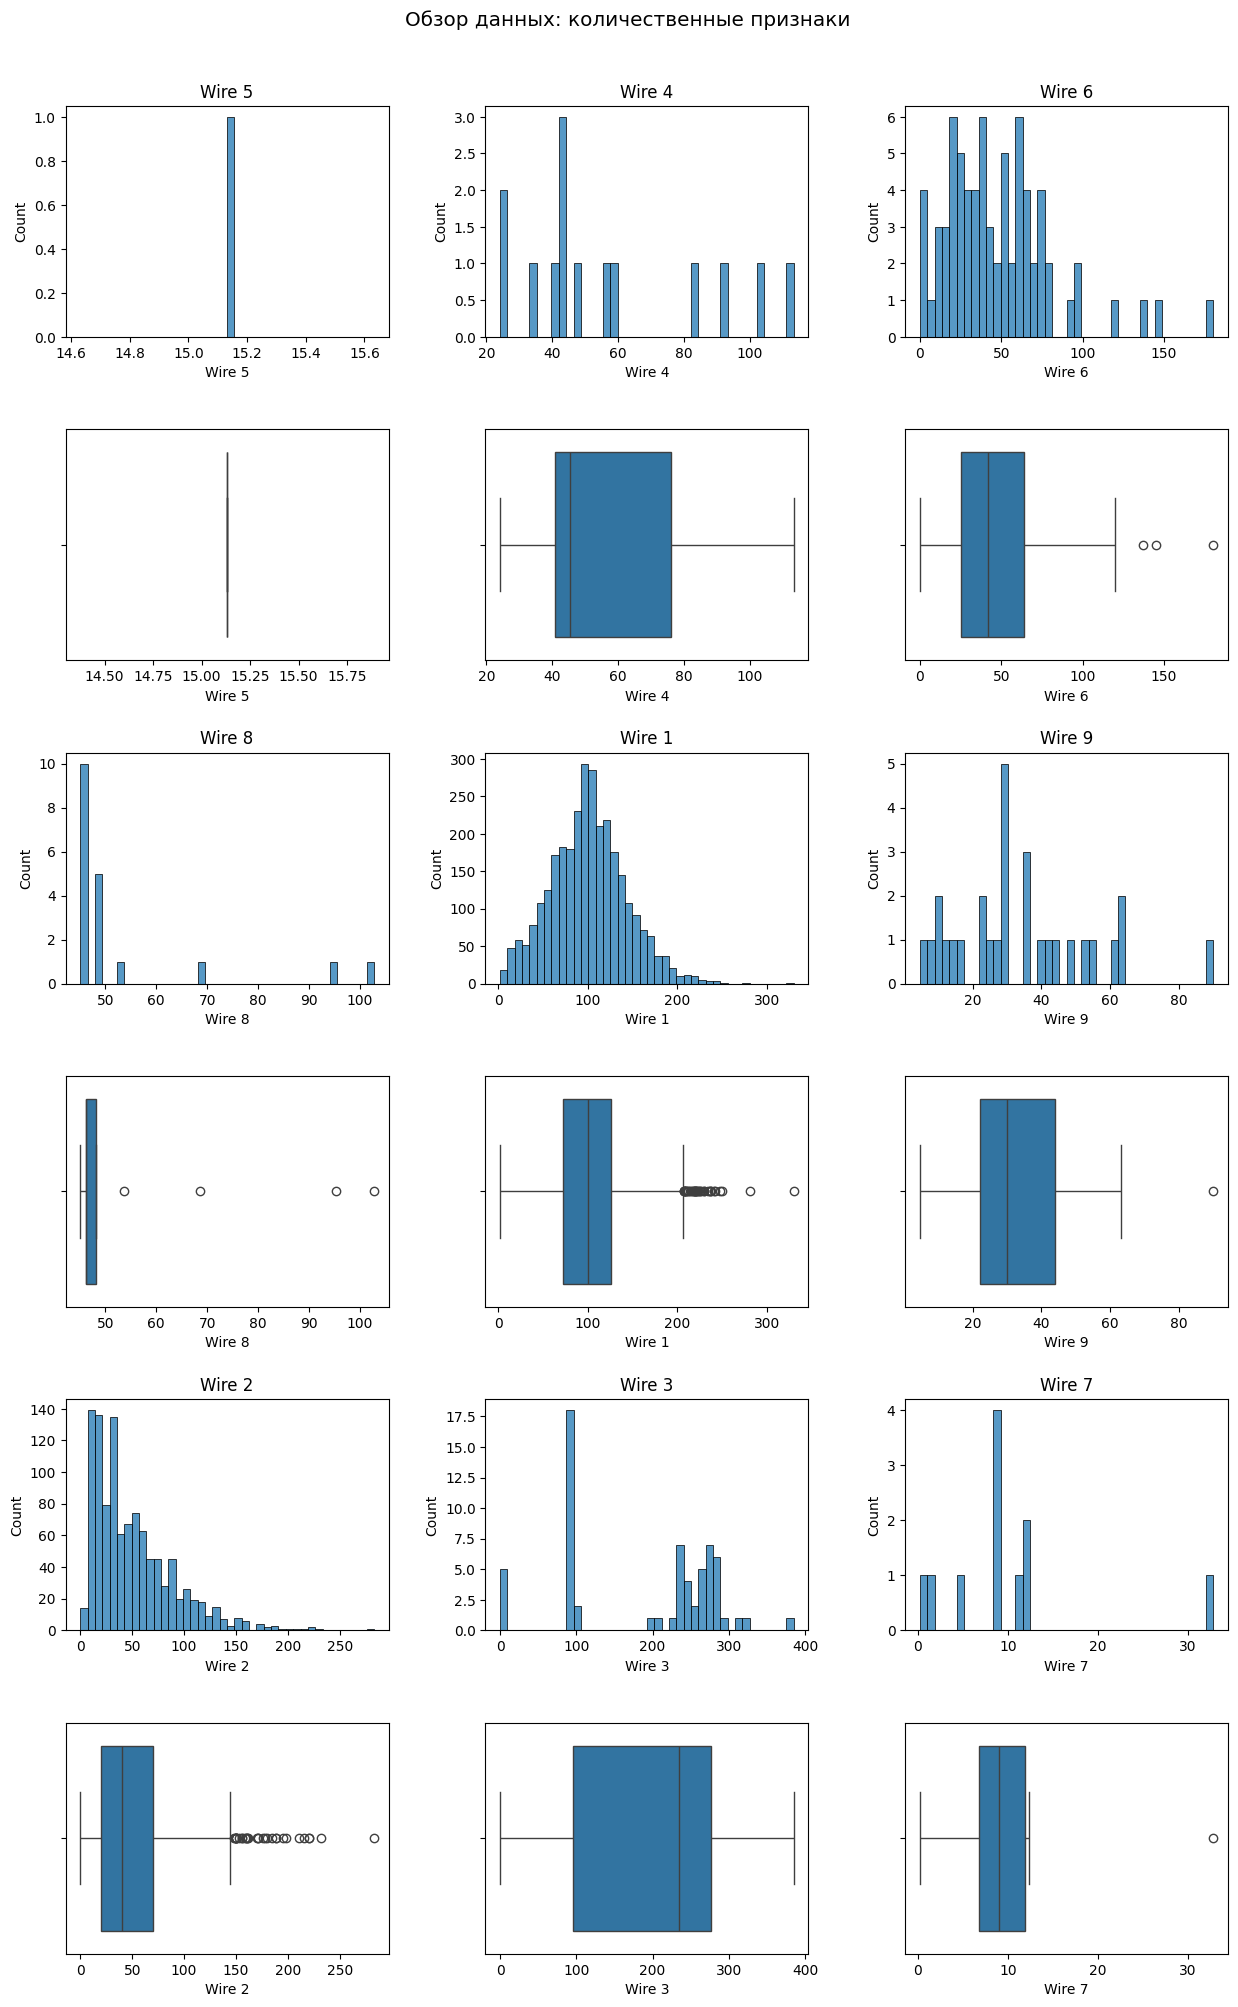

In [80]:
research_data_analysis_plots(df_wire_volume, except_col=['key'])

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,total_wire_vol
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.059998
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.052315
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.160157


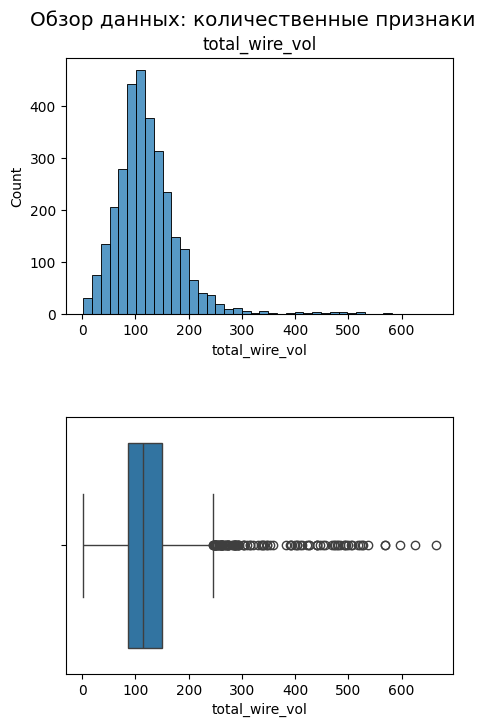

In [81]:
# Добавим новый параметр - общий объем проволочных материалов
df_wire_volume['total_wire_vol'] = df_wire_volume.loc[:,'Wire 1':'Wire 9'].sum(axis=1)
display(df_wire_volume.head(3))
research_data_analysis_plots(df_wire_volume, include_col=['total_wire_vol'])

In [82]:
# Посмотрим частоту применения каждой из проволочных добавок
list_ = []
for i in df_wire_volume.columns:

    list_.append(round((1-df_wire_volume[i].isna().sum() / df_wire_volume.shape[0]) * 100, 2))
df_ = pd.DataFrame(index=df_wire_volume.columns, data=list_, columns=['share_of_use']).drop(index='key')
df_

,share_of_use
Wire 1,99.16
Wire 2,35.02
Wire 3,2.04
Wire 4,0.45
Wire 5,0.03
Wire 6,2.37
Wire 7,0.36
Wire 8,0.62
Wire 9,0.94
total_wire_vol,100.00


In [83]:
# Объемы редко используемых добавок (менее 10% партий) удалим
df_wire_volume.drop(columns=df_.query('share_of_use < 10').index, inplace=True)
df_wire_volume.head(3)

,key,Wire 1,Wire 2,total_wire_vol
0,1,60.059998,NaN,60.059998
1,2,96.052315,NaN,96.052315
2,3,91.160157,NaN,91.160157


In [84]:
# Заполним пропущенные значения нулями
df_wire_volume.fillna(0, inplace=True)
df_wire_volume.head(3)

,key,Wire 1,Wire 2,total_wire_vol
0,1,60.059998,0.0,60.059998
1,2,96.052315,0.0,96.052315
2,3,91.160157,0.0,91.160157


Выводы по датафрейму df_wire_volume:
1. Приведены данные о 9 проволочных добавках
2. Проволочная добавка №1 используется почти во всех партиях (99.1%), №2 - в 35%, остальные - мнеее 3%
3. Добавлен параметр: общий объем проволочных материалов
4. Объемы редко использованных проволочных материалов (мене 10% партий) удалены.
5. Пропуски заполнены нулями

### Данные о времени подачи проволочных материалов: df_wire_time

In [85]:
df_wire_time.head(3)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
print('Наблюдений в датасете:', df_wire_time.shape[0],
      '\nУникальных партий:', df_wire_time.key.nunique())

Наблюдений в датасете: 3081 
Уникальных партий: 3081


Выводы по датафрейму df_wire_time:
1. Приведены данные о 9 проволочных материалах.
2. Подача разных проволочных материалов происходит неодновременно  

## Объединение данных

Подготовим данные для объединения.  
Объединять будем по номеру партии, поэтому аггрегация по данному параметру

In [87]:
# df_arc. Суммируем значения мощности, длительности нагрева в каждой партии. Количество итераций и длительность партии - без изменений
df_arc_agg = df_arc.groupby('key').agg({'Активная мощность':'sum',
                                    'Реактивная мощность':'sum',
                                    'total_power':'sum',
                                    'heat_dur':'sum',
                                    'power_consump':'sum',
                                    'iter_num':'min',
                                    'batch_dur':'min'
                                    })
df_arc_agg.rename(columns={'Активная мощность':'active_power', 'Реактивная мощность':'reactive_power'}, inplace=True)
df_arc_agg.reset_index(inplace=True)
df_arc_agg.head(3)

,key,active_power,reactive_power,total_power,heat_dur,power_consump,iter_num,batch_dur
0,1,3.036730,2.142821,3.718736,1098,770.282114,5,1583
1,2,2.139408,1.453357,2.588349,811,481.760005,4,1144
2,3,4.063641,2.937457,5.019223,655,722.837668,5,1525


In [88]:
# Из df_temperature возьмем начальную и финальную температуру, а также определим минимальную и максимальную темп. в промежуточных итерациях
df_temperature_agg = df_temperature.query('first_measurement == 1')[['key', 'Температура']].rename(columns={'Температура':'first_temp'})
df_temp_ = df_temperature.query('final_measurement == 1')[['key', 'Температура']].rename(columns={'Температура':'final_temp'})
df_temperature_agg = df_temperature_agg.merge(df_temp_, how='left')

df_temp_ = df_temperature[(df_temperature.first_measurement == 0) & (df_temperature.final_measurement == 0)]  \
            .groupby('key')  \
            .agg({'Температура':['min', 'max']})
df_temp_.columns = df_temp_.columns.droplevel(0)
df_temp_.reset_index(inplace=True)

df_temperature_agg = df_temperature_agg.merge(df_temp_, how='left')
df_temperature_agg.rename(columns={'min':'min_temp', 'max':'max_temp'}, inplace=True)
df_temperature_agg.head(10)

,key,first_temp,final_temp,min_temp,max_temp
0,1,1571.0,1613.0,1601.0,1618.0
1,2,1581.0,1602.0,1577.0,1604.0
2,3,1596.0,1599.0,1597.0,1600.0
3,4,1601.0,1625.0,1617.0,1623.0
4,5,1576.0,1602.0,1586.0,1592.0
5,6,1543.0,1596.0,1581.0,1600.0
6,7,1586.0,1599.0,1582.0,1599.0
7,8,1577.0,1598.0,1600.0,1604.0
8,9,1587.0,1592.0,1586.0,1597.0
9,10,1574.0,1593.0,1580.0,1586.0


In [89]:
# в партиях, где только два измерения температуры, минимальное и максимальное значение заполним исходным
df_temperature_agg.min_temp.fillna(df_temperature_agg.first_temp, inplace=True)
df_temperature_agg.max_temp.fillna(df_temperature_agg.first_temp, inplace=True)

C:\Users\Илья\AppData\Local\Temp\ipykernel_9280\3869780462.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_temperature_agg.min_temp.fillna(df_temperature_agg.first_temp, inplace=True)
C:\Users\Илья\AppData\Local\Temp\ipykernel_9280\3869780462.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 

In [90]:
# df_bulk_volume. Приведем названия столбцов к "змеиному" стилю и заменим пробелы на андерскор
df_bulk_volume.columns = df_bulk_volume.columns.str.lower().str.replace(' ', '_')
df_bulk_volume.head(3)

,key,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,total_bulk_vol
0,1,0.0,43.0,0.0,206.0,150.0,154.0,553.0
1,2,0.0,73.0,0.0,206.0,149.0,154.0,582.0
2,3,0.0,34.0,0.0,205.0,152.0,153.0,544.0


In [91]:
# df_wire_volume. Приведем названия столбцов к "змеиному" стилю и заменим пробелы на андерскор
df_wire_volume.columns = df_wire_volume.columns.str.lower().str.replace(' ', '_')
df_wire_volume.head(3)

,key,wire_1,wire_2,total_wire_vol
0,1,60.059998,0.0,60.059998
1,2,96.052315,0.0,96.052315
2,3,91.160157,0.0,91.160157


In [92]:
# df_gas. Переименуем столбецы
df_gas.rename(columns={'Газ 1':'gas'}, inplace=True)
df_gas.head(3)

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793


In [93]:
# Объединяем датафреймы
df_summary = df_arc_agg
for i in (df_temperature_agg, df_bulk_volume, df_wire_volume, df_gas):
    df_summary = df_summary.merge(i, on='key', how='inner')

df_summary.drop(columns='key', inplace=True)
with pd.option_context('display.max_rows', None):
    print('Дубликатов:', df_summary.duplicated().sum(),
        '\nПропусков:', df_summary.isna().sum().sum(),
        '\nСтрок:', df_summary.shape[0],
        '\nСтолбцов:', df_summary.shape[1])

with pd.option_context('display.max_columns', None):
    display(df_summary.head(10))

Дубликатов: 0 
Пропусков: 0 
Строк: 2325 
Столбцов: 22


,active_power,reactive_power,total_power,heat_dur,power_consump,iter_num,batch_dur,first_temp,final_temp,min_temp,max_temp,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,total_bulk_vol,wire_1,wire_2,total_wire_vol,gas
0,3.036730,2.142821,3.718736,1098,770.282114,5,1583,1571.0,1613.0,1601.0,1618.0,0.0,43.0,0.0,206.0,150.0,154.0,553.0,60.059998,0.000000,60.059998,29.749986
1,2.139408,1.453357,2.588349,811,481.760005,4,1144,1581.0,1602.0,1577.0,1604.0,0.0,73.0,0.0,206.0,149.0,154.0,582.0,96.052315,0.000000,96.052315,12.555561
2,4.063641,2.937457,5.019223,655,722.837668,5,1525,1596.0,1599.0,1597.0,1600.0,0.0,34.0,0.0,205.0,152.0,153.0,544.0,91.160157,0.000000,91.160157,28.554793
3,2.706489,2.056992,3.400038,741,683.455597,4,1093,1601.0,1625.0,1617.0,1623.0,0.0,81.0,0.0,207.0,153.0,154.0,595.0,89.063515,0.000000,89.063515,18.841219
4,2.252950,1.687991,2.816980,869,512.169934,4,1362,1576.0,1602.0,1586.0,1592.0,0.0,78.0,0.0,203.0,151.0,152.0,584.0,89.238236,9.114560,98.352796,5.413692
5,2.725274,1.881313,3.313074,952,839.231310,4,1353,1543.0,1596.0,1581.0,1600.0,0.0,117.0,0.0,204.0,201.0,154.0,676.0,99.109917,9.114560,108.224477,11.273392
6,2.626877,1.960419,3.283913,673,613.576982,4,1469,1586.0,1599.0,1582.0,1599.0,0.0,117.0,0.0,204.0,152.0,154.0,627.0,98.061600,0.000000,98.061600,9.836267
7,2.678958,2.096952,3.405956,913,619.129542,4,1432,1577.0,1598.0,1600.0,1604.0,0.0,99.0,0.0,410.0,252.0,153.0,914.0,155.282394,0.000000,155.282394,15.171553
8,3.520820,2.527365,4.335261,625,570.113675,5,1566,1587.0,1592.0,1586.0,1597.0,0.0,117.0,0.0,107.0,99.0,203.0,526.0,113.393279,9.143681,122.536960,8.216623
9,3.118778,2.154941,3.791005,825,533.482050,6,1422,1574.0,1593.0,1580.0,1586.0,0.0,0.0,0.0,203.0,102.0,204.0,509.0,81.244796,12.376000,93.620796,6.529891


1. В результате объедининия получили итоговый датафрейм, содержащий 2323 наблюдения (уникальных партии), 22 параметра, таргет - финальная температура.
2. Параметры: 
* мощность: активная, пассивная, полная
* суммарная продолжительность включения электродов на одну партию
* длительность обработки каждой партии (от первого включения элетродов до окончания последнего включения)
* начальная температура сплава
* минимальная и максимальная температура сплава в промежуточных итерациях нагрева
* индивидуальный объем девяти сыпучих добавок, суммарный объеме редко используемых добавок, общий объем всех сыпучих добавок
* индивидуальный объем (метраж) четырех проволочных добавок, сумарный объем редко используемых добавок, общий объем всех проволочных добавок
* объем использованного газа для продувки
3. Дубликатов нет.
4. Пропусков нет.

## Исследовательский анализ и предобработка данных объединённого датафрейма

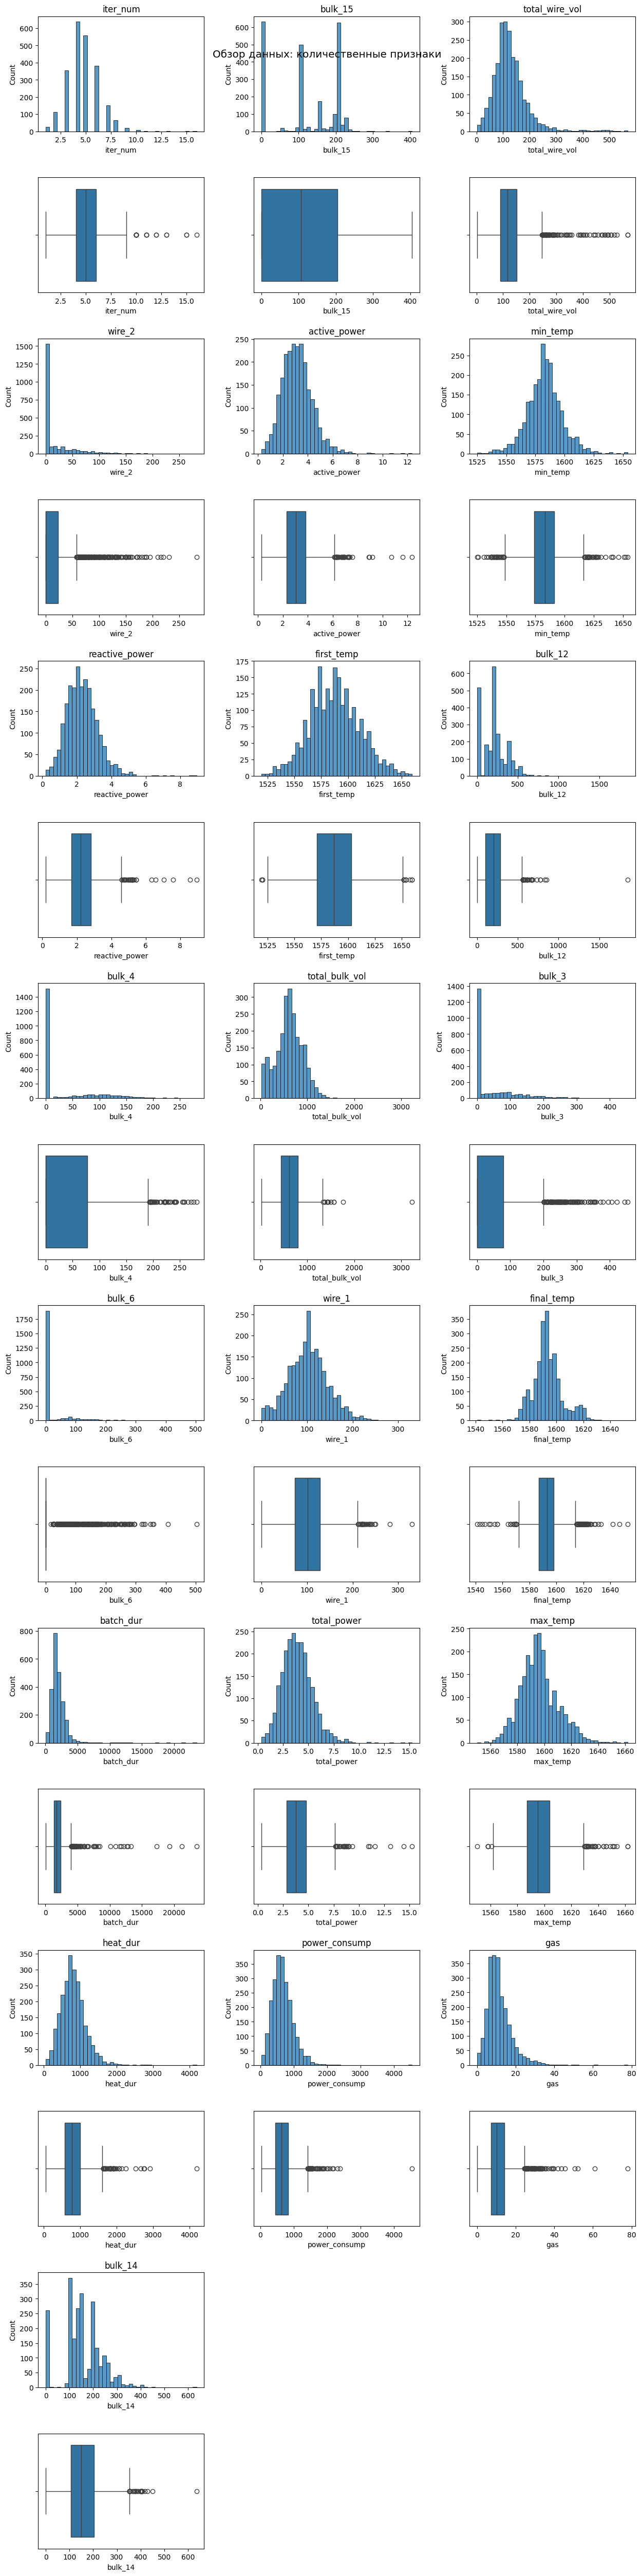

In [94]:
# Посмотрим на распределение признаков в обобщенном датасете.
research_data_analysis_plots(df_summary)

Определим выбросы в параметрах мощности, длительности нагрева и количестве итераций. Сохраним индексы партий с выбросами. Позже удалим выбросы по индексу только из обучающей выборки.

In [95]:
def delete_outliers (df_, cols=[]):
    """ Определение выбросов (по 1.5*IQR)
        Возвращает список уникальных индексов записей.
    """
    res = []
    for i in cols:
        iqr_ = df_[i].quantile(0.75) - df_[i].quantile(0.25)
        upper_bound = df_[i].quantile(0.75) + iqr_ * 1.5
        lower_bound = df_[i].quantile(0.25) - iqr_ * 1.5
        res = res + list(df_.loc[(df_[i] > upper_bound) | (df_[i] < lower_bound)].index)
    return list(set(res))

In [96]:
# Сохраним индексы партий с выбросами.
indexes_to_delete = delete_outliers(df_summary, ['batch_dur', 'total_power', 'iter_num', 'power_consump'])
print('Подлежит удалению партий:', len(indexes_to_delete))

Подлежит удалению партий: 119


In [97]:
df_summary.head(3)

,active_power,reactive_power,total_power,heat_dur,power_consump,iter_num,batch_dur,first_temp,final_temp,min_temp,...,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,total_bulk_vol,wire_1,wire_2,total_wire_vol,gas
0,3.036730,2.142821,3.718736,1098,770.282114,5,1583,1571.0,1613.0,1601.0,...,43.0,0.0,206.0,150.0,154.0,553.0,60.059998,0.0,60.059998,29.749986
1,2.139408,1.453357,2.588349,811,481.760005,4,1144,1581.0,1602.0,1577.0,...,73.0,0.0,206.0,149.0,154.0,582.0,96.052315,0.0,96.052315,12.555561
2,4.063641,2.937457,5.019223,655,722.837668,5,1525,1596.0,1599.0,1597.0,...,34.0,0.0,205.0,152.0,153.0,544.0,91.160157,0.0,91.160157,28.554793


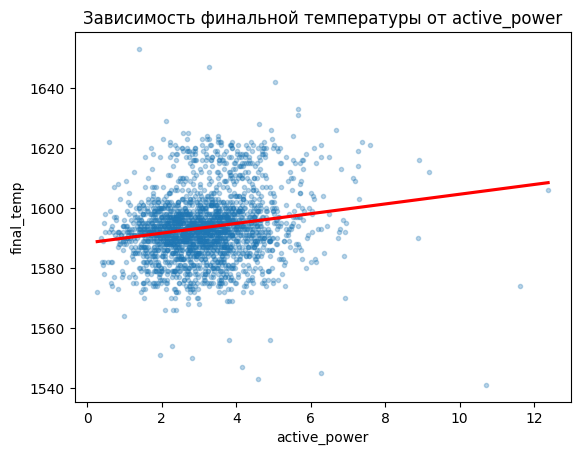

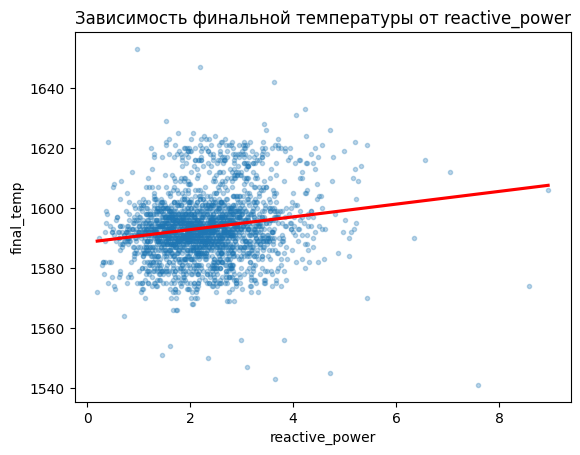

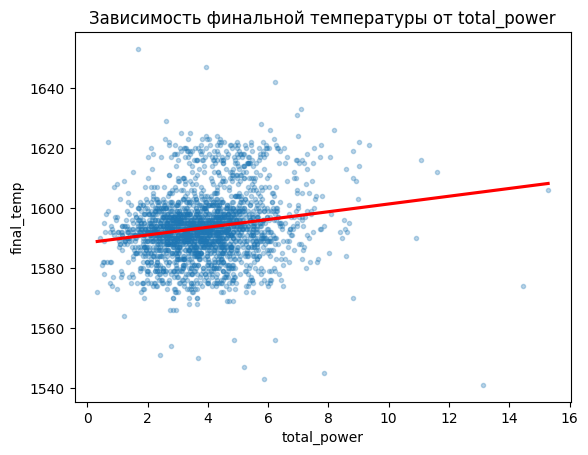

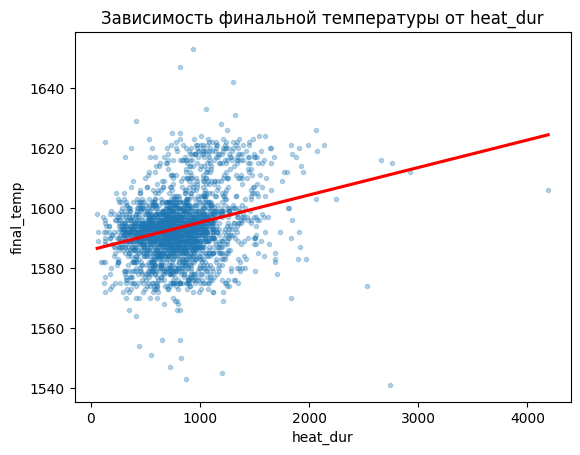

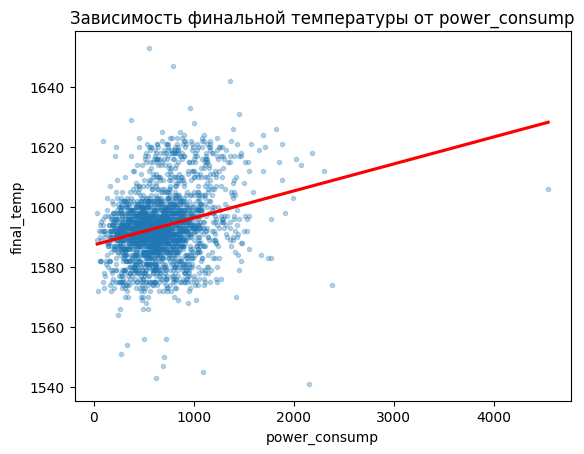

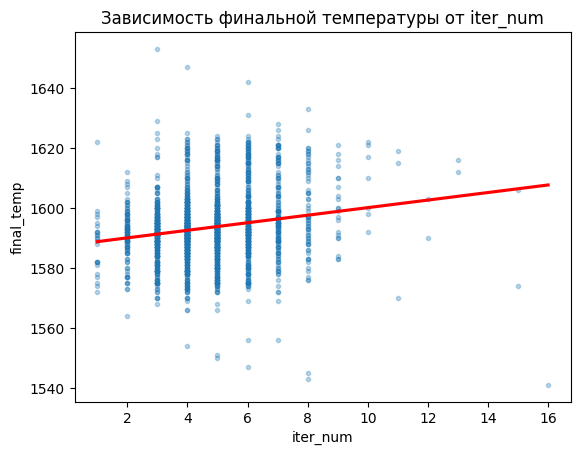

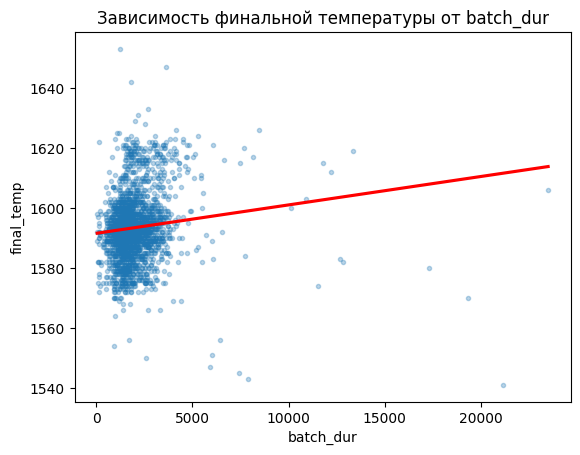

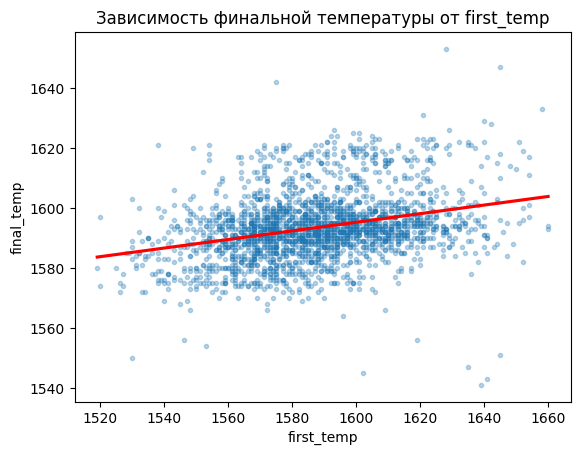

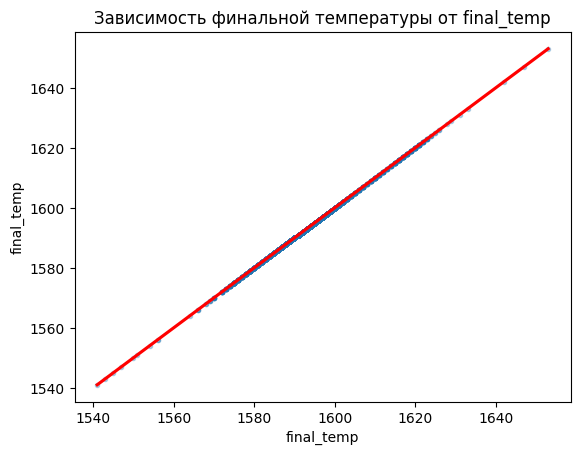

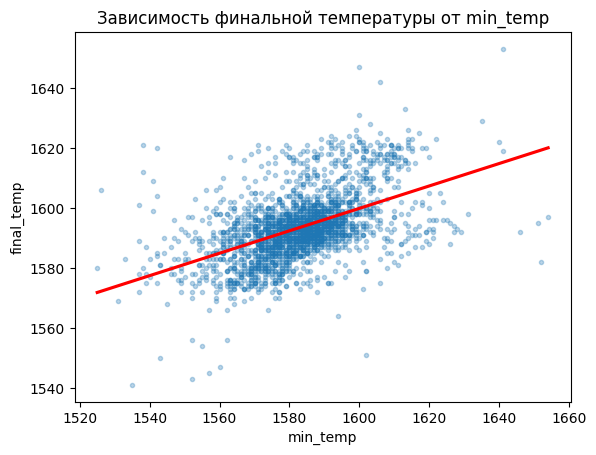

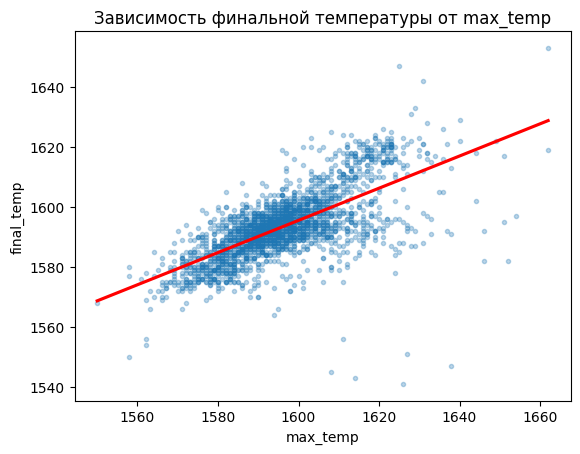

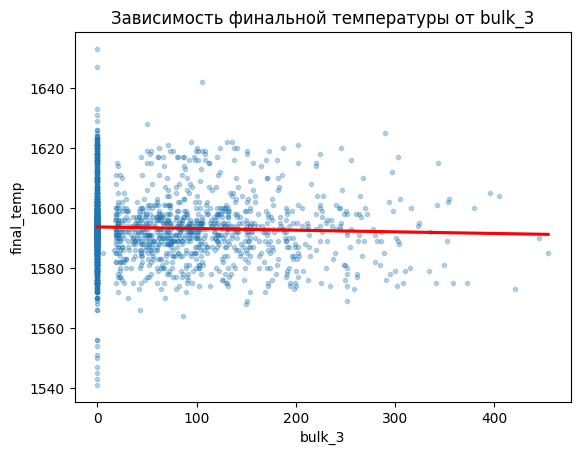

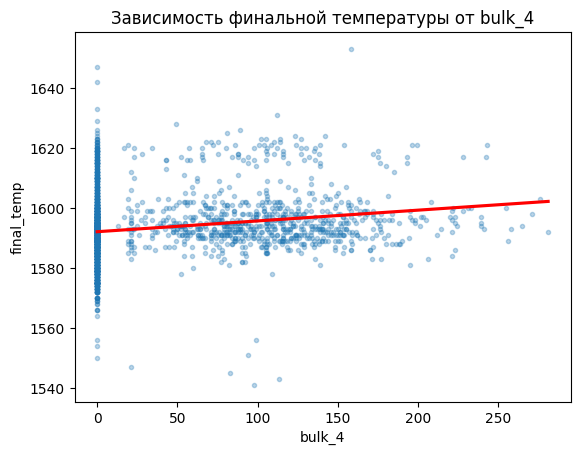

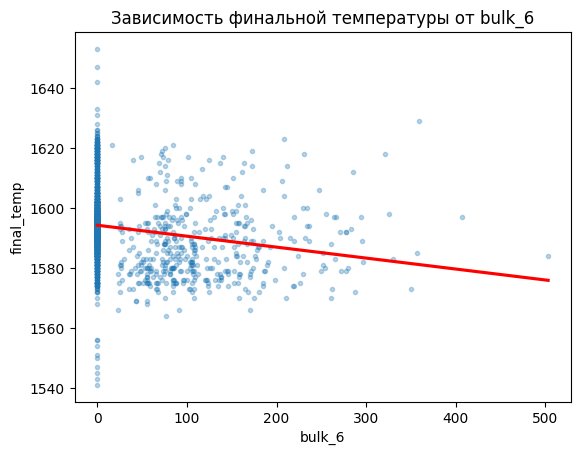

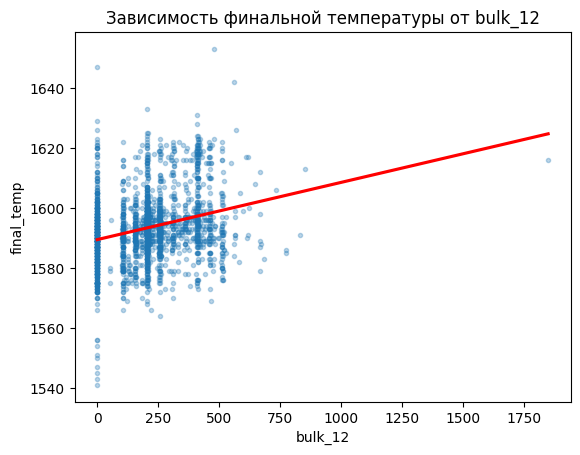

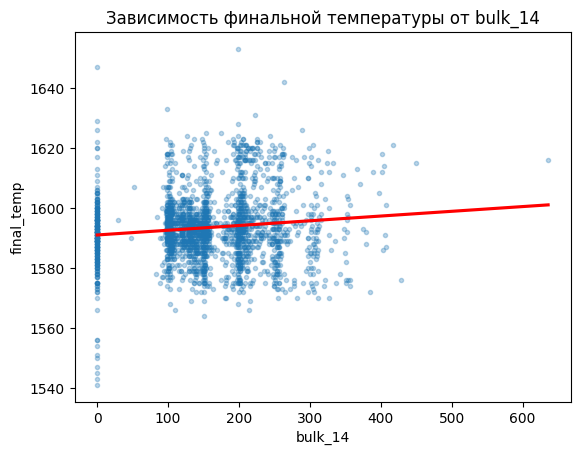

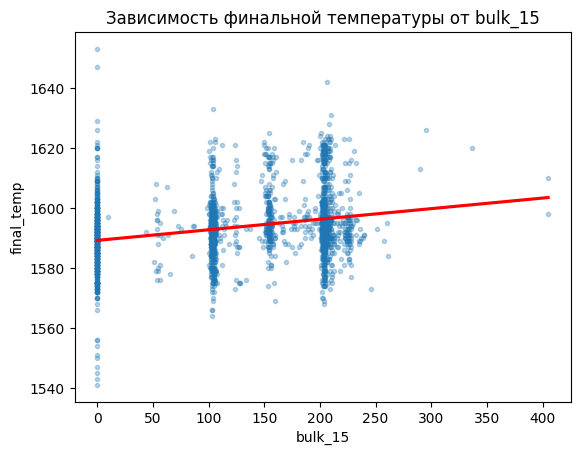

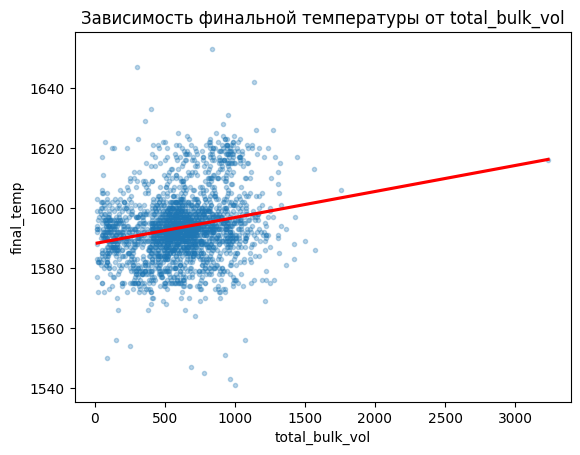

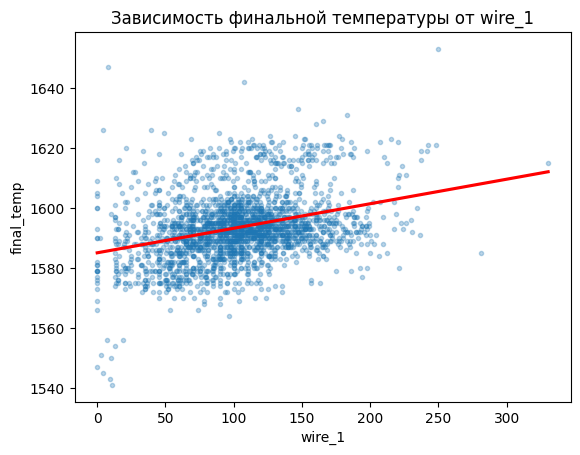

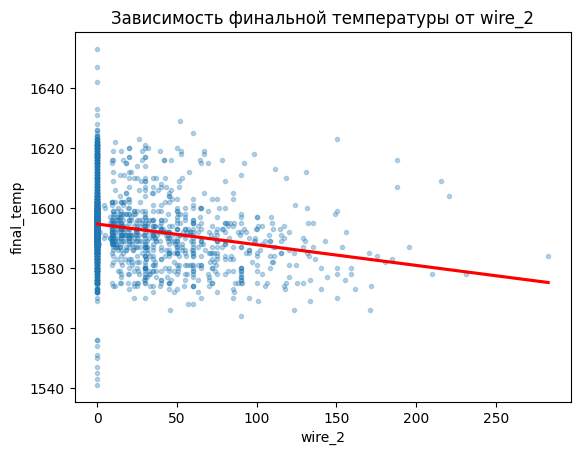

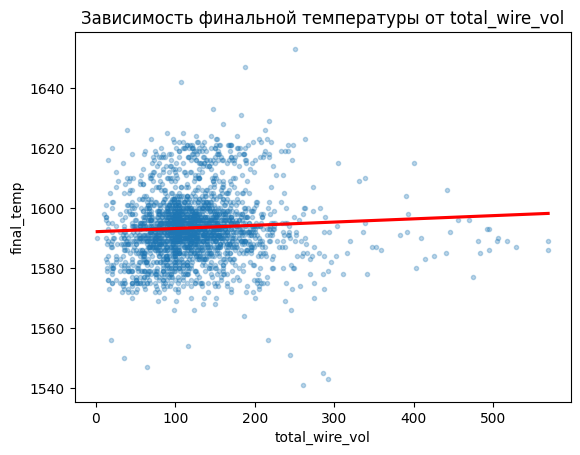

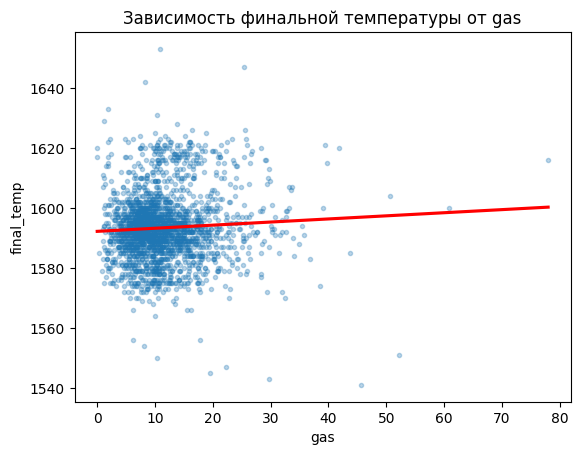

In [98]:
# Оценим визуально зависимость таргета от параметров (данные без выборосов)
for i in df_summary.drop(index=indexes_to_delete).columns:
    sns.regplot(data=df_summary,
                          x=i,
                          y='final_temp',
                          marker='.',
                          ci=None,
                          line_kws=dict(color='r'),
                          scatter_kws=dict(alpha=0.3)
                          ).set(title='Зависимость финальной температуры от ' + i)
    plt.show()

Анализируя диаграммы рассеяния можно сделать следующие выводы:
1. Достаточно выраженная линейная зависимость финальной температуры наблюдается с минимальной и максимальной температурой на промежуточных итерациях.
2. Умеренная зависимость финальной температуры наблюдается с параметрами:
* Длительность нагрева
* Начальная температура сплава
* Общий объем сыпучих добавок
* Объем (метраж) проволочных компонентов №1 и №2
3. Явных нелинейных зависимостей таргета и параметров на графике не отмечается.

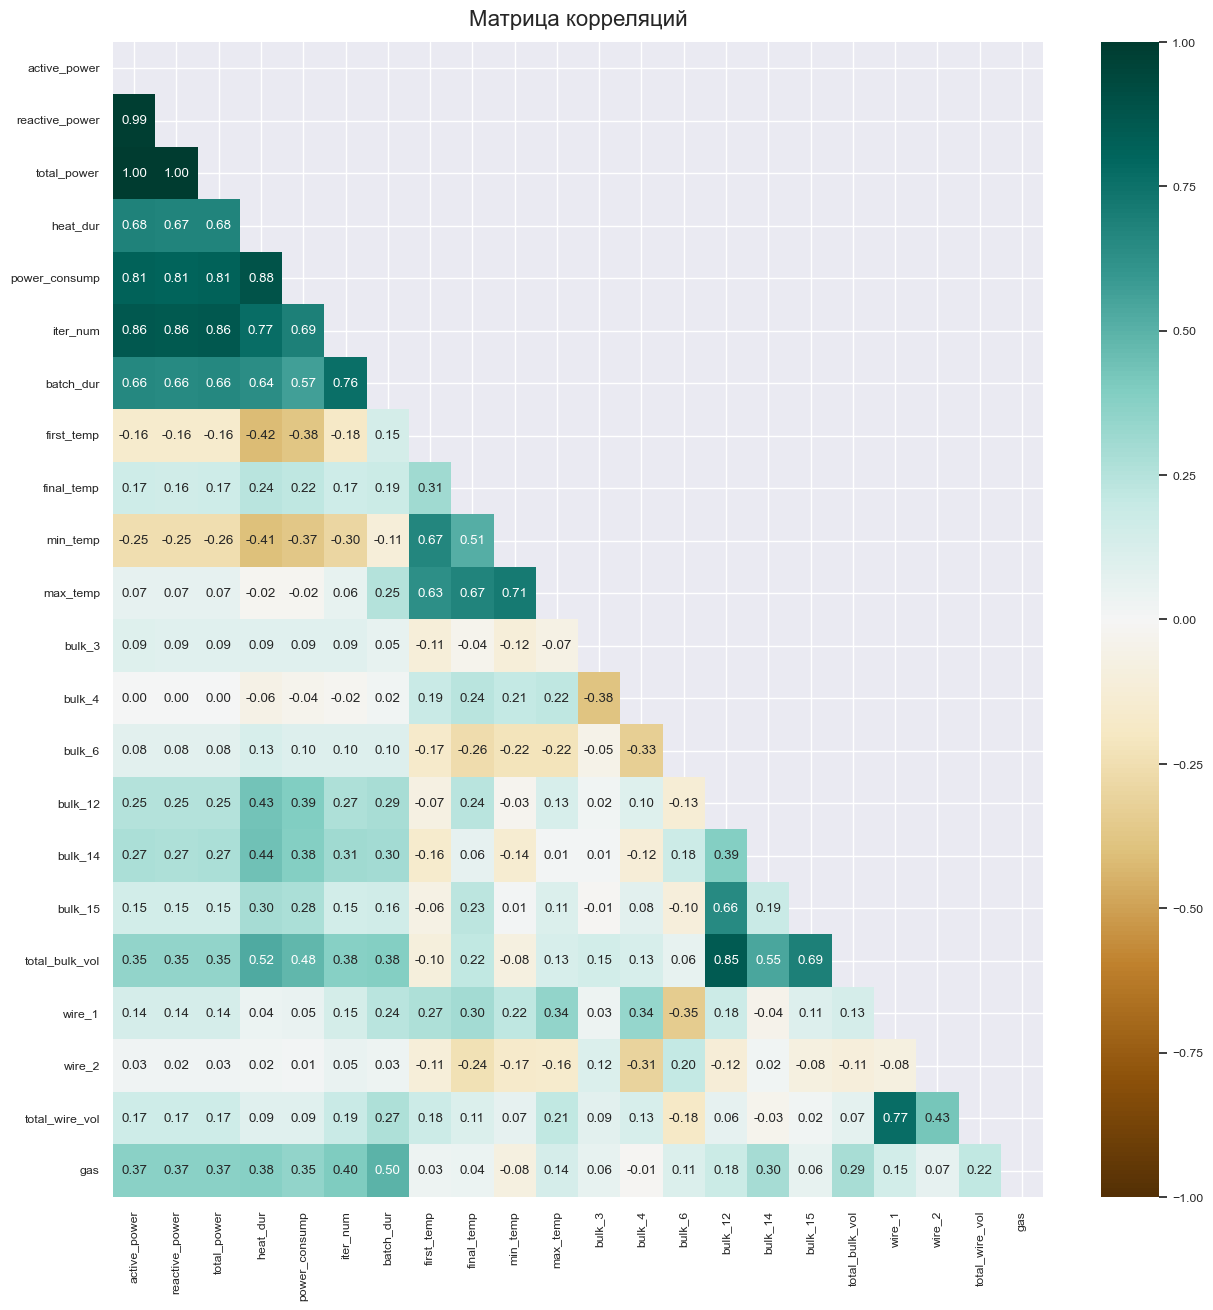

In [99]:
# Проведем корреляционный анализ
matr_corr = df_summary.corr(method='spearman')
mask = np.triu(np.ones_like(df_summary.corr()))
sns.set(font_scale=0.8)
plt.figure(figsize=(15, 15))
heatmap = sns.heatmap(matr_corr,
                        vmin=-1,
                        vmax=1,
                        annot=True,
                        fmt='.2f',
                        cmap="BrBG",
                        mask=mask)
heatmap.set_title('Матрица корреляций', fontdict={'fontsize':16}, pad=12);
plt.show()

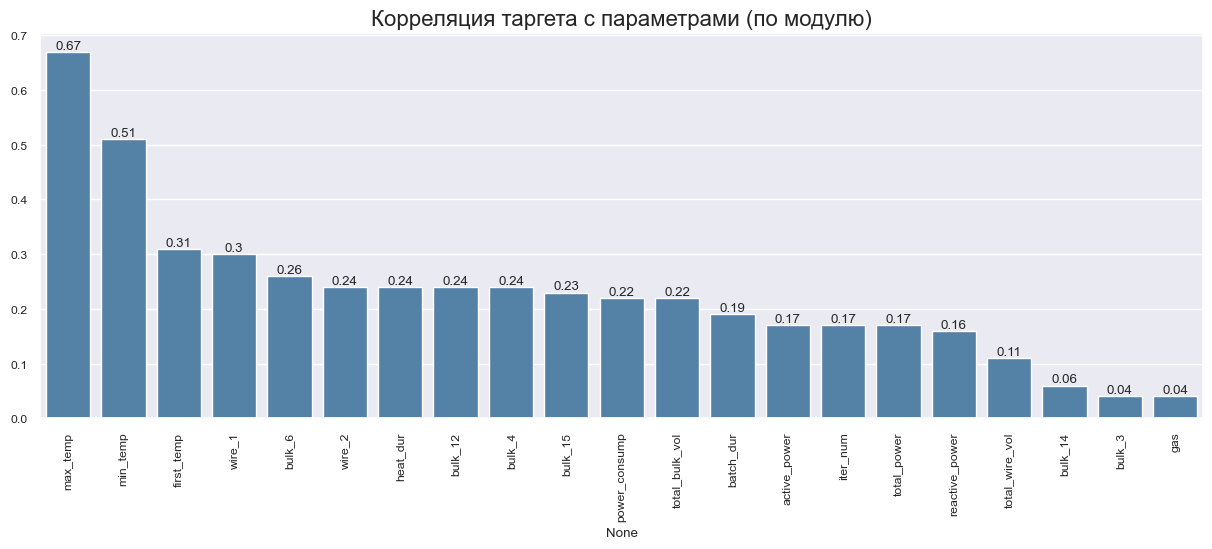

In [100]:
# Корреляцию таргета с параметрами для удобства отобразим на отдельном графике
corr = pd.Series()
for i in df_summary.columns:
    corr[i] = round(abs(df_summary.final_temp.corr(df_summary[i], method='spearman')), 2)
corr = corr.sort_values(ascending=False)[1:]

plt.figure(figsize=(15, 5))
bar = sns.barplot(x=corr.index, y=corr.values, color='steelblue')
bar.set_title('Корреляция таргета с параметрами (по модулю)', fontdict={'fontsize':16})
bar.tick_params(axis='x', rotation=90)
bar.bar_label(bar.containers[0]);


1. Выявлена  корреляция таргета средней силы (0.5-0.7) с минимальной и максимальной температурой сплава на промежуточных итерациях
2. Имеется корреляция средней силы (0.3-0.5) таргета с начальной температурой сплава
3. Выявлена очень слабая корреляция таргета (0.1-0.3) с параметрами:
* длительность включения электродов, расход электроэнергии
* длительность обработки одной партии
* объем сыпучих компонентов №4, 6, 12, 15
* объем проволочных компонентов №1, 2
4. Отсутствует корреляция с таргетом у сыпучих компонентах 3 и 14, объема газа, общего объема проволочных компонентов - удаляем.
5. Выявлена сильная корреляция:
* между показателями мощности - активной, реактивной и полной. Оставляем полную мощность, удаляем реактивную и активную. 
* между расходом электроэнергии и время включения электродов - удаляем время включния электродов.

In [101]:
df_summary.drop(columns=['active_power', 'reactive_power', 'bulk_3', 'bulk_14', 'gas', 'total_wire_vol', 'heat_dur'], inplace=True)
df_summary.head(3)

,total_power,power_consump,iter_num,batch_dur,first_temp,final_temp,min_temp,max_temp,bulk_4,bulk_6,bulk_12,bulk_15,total_bulk_vol,wire_1,wire_2
0,3.718736,770.282114,5,1583,1571.0,1613.0,1601.0,1618.0,43.0,0.0,206.0,154.0,553.0,60.059998,0.0
1,2.588349,481.760005,4,1144,1581.0,1602.0,1577.0,1604.0,73.0,0.0,206.0,154.0,582.0,96.052315,0.0
2,5.019223,722.837668,5,1525,1596.0,1599.0,1597.0,1600.0,34.0,0.0,205.0,153.0,544.0,91.160157,0.0


В ходе исследовательского анализа объедениненного датасета
1. Визуализирована зависимость таргета и параметров, выявлены признаки с сильной линейной зависиомостью. Нелинейных зависимостей не выявлено.
2. Оценено распределение данных для каждого параметра. Выявлены выбросы для последующего удаления из тренировочной выборки.
3. Изучена корреляция. Удалены высокоскореллированные между собой признаки, а также признаки без корреляции с таргетом.

## Подготовка данных

In [102]:
# Раздели данные на тест и трейн
X = df_summary.drop(columns='final_temp')
y = df_summary.final_temp

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)

(1743, 14)
(582, 14)
(1743,)
(582,)


In [103]:
# Удалим ранее определенные партии с выбросами из тренировочный выборки.
X_train.drop(index=indexes_to_delete, inplace=True, errors='ignore')
y_train.drop(index=indexes_to_delete, inplace=True, errors='ignore')
print(X_train.shape, y_train.shape)

(1649, 14) (1649,)


In [104]:
# Создадим датафрейм для фиксации метрик разных моделей
df_metrics = pd.DataFrame()

1. Даные разделены на тест и трейн в соотношении 1:3
2. Из трейна удалены ранее определенные выбросы
3. В тестовой выборке 582 наблюдение, в тренировочной - 1649, параметров - 14.

## Обучение моделей

### Линейная регрессия

In [105]:
# Масштабируем данные
scaler = MinMaxScaler()
X_train_lr = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

In [106]:
# Обучаем модель, используем кросс-валидацию, фиксируем метрику
model_lr = LinearRegression()
metrics_cv = cross_val_score(model_lr, X_train_lr, y_train, cv=5, scoring='neg_mean_absolute_error')
df_metrics.loc['LinReg', 'MAE'] = round(abs(metrics_cv.mean()), 2)
print('Метрики моделей:\n ', df_metrics)

Метрики моделей:
           MAE
LinReg  4.66


### Случайный лес

In [107]:
# Обучаем модель, используем кросс-валидацию, фиксируем метрику
model_rf = RandomForestRegressor(random_state=RANDOM_STATE)
params_rf = {
    'n_estimators': np.arange(10, 200).tolist()[0::5],
    'max_depth': np.arange(2, 30).tolist()[0::2],
    'min_samples_split':np.arange(2, 11).tolist()[0::2],
    'max_leaf_nodes': np.arange(10, 100).tolist()[0::5],
    'bootstrap': [True, False]
}

rand_search_rf = RandomizedSearchCV(
    model_rf,
    params_rf,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rand_search_rf.fit(X_train, y_train)
print('Параметры лучшей модели:\n', rand_search_rf.best_params_)
df_metrics.loc['RandForest', 'MAE'] = round(abs(rand_search_rf.best_score_), 2)
print('Метрики моделей:\n ', df_metrics)


Параметры лучшей модели:
 {'n_estimators': 145, 'min_samples_split': 2, 'max_leaf_nodes': 75, 'max_depth': 12, 'bootstrap': True}
Метрики моделей:
               MAE
LinReg      4.66
RandForest  4.41


### Градиентный бустинг

In [108]:
# Обучаем модель, используем кросс-валидацию, фиксируем метрику
model_lgbm = LGBMRegressor(objective='regression', random_state=RANDOM_STATE)
params_lgbm = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': np.arange(10, 80).tolist()[0::10],
    'max_depth': [4, 6],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'subsample': [0.7, 0.8, 0.9],
    'min_child_samples': np.arange(1, 20).tolist()[0::5]
}

rand_search_lgbm = RandomizedSearchCV(
    model_lgbm,
    params_lgbm,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rand_search_lgbm.fit(X_train, y_train)
print('Параметры лучшей модели:\n', rand_search_lgbm.best_params_)
df_metrics.loc['LGBM', 'MAE'] = round(abs(rand_search_lgbm.best_score_), 2)
print('Метрики моделей:\n ', df_metrics)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2243
[LightGBM] [Info] Number of data points in the train set: 1649, number of used features: 14
[LightGBM] [Info] Start training from score 1593.236507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Обучены три модели: линейная регрессия, случайный лес, градиентный бустинг (LightBGM).  
На кросс-валидации получены следующие метрики:  
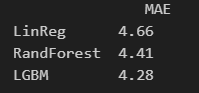

## Выбор лучшей модели

Все три модели укладываются в пороговое значение МАЕ 6.8 и менее.  
Максимальное качество у модели на основе LightGBM.  
Проверим ее качество на тестовых данных и сравним с константной моделью.

In [109]:
# Проверим качество модели на тесте
print('MAE на тестовой выборке:', round(abs(mean_absolute_error(y_test, rand_search_lgbm.best_estimator_.predict(X_test))), 2))

MAE на тестовой выборке: 4.41


In [110]:
# Посчитаем метрику для константной модели
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
print('MAE на константной модели:', round(abs(mean_absolute_error(y_test, dummy.predict(X_test))), 2))

MAE на константной модели: 8.28


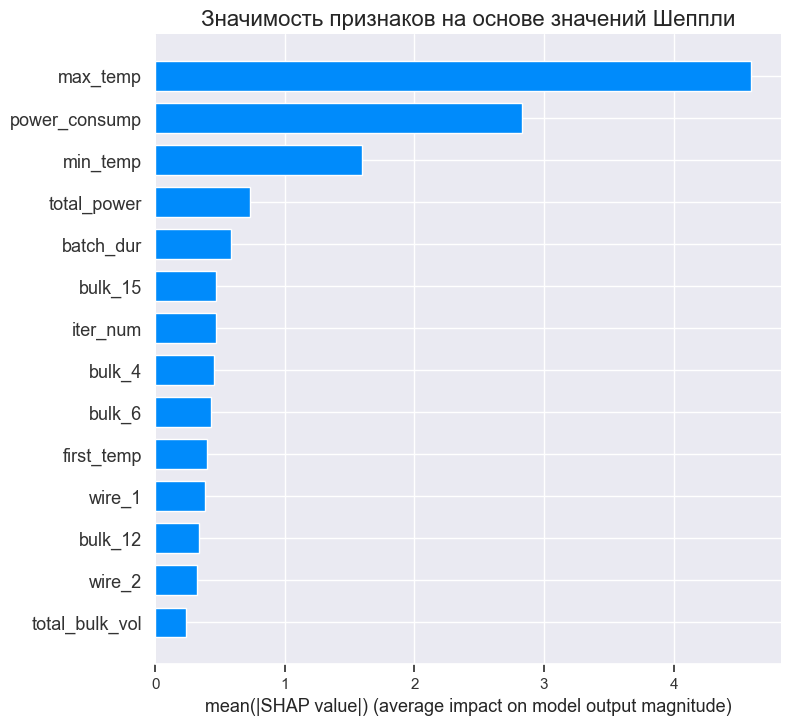

In [111]:
# Оценим значимость признаков выбранной модели
shap_test = shap.Explainer(rand_search_lgbm.best_estimator_).shap_values(X)
shap.summary_plot(shap_test, X, plot_type='bar', show=False)
plt.title('Значимость признаков на основе значений Шеппли', fontdict={'size':16})
plt.show()

1. Лучшей моделью оказалась модель на основе LightGBM с МАЕ 4.28 на кросс-валидации.
2. МАЕ выбранной модели на тестовых данных 4.41, что близко к значениям на трейне.
3. Константная модель показала МАЕ 8.28, что существенно выше показателей выбранной модели.
4. При анализе важности признаков установлено:
* Наибольшее влияние оказывает значение максимальной температуры на промежуточных итерациях
* Существеный вклад также вносят расход электроэнергии и минимальная температура на промежуточных итерациях.
* Общая мощность, длительность обработки одной партии, количество итераций нагрева, начальная температура, объем проволочных материалов, объем сыпучих компонентов №4, 6, 12, 15, а также проволочных №1 и 2 оказывают менее значимые сопостовимые влияния на величину прогнозируемого таргета. 

## Общий вывод и рекомендации заказчику

1. Целью проекта было предсказание финальной температуры сплава. Предоставлены 7 отдельных датасетов с данными о примерно 3200 партиях.
2. На этапе исследовательского анализа и предобработки данных:
* изучено распределение данных
* удалены аномалии, вызванные отклонениями от технологического процесса
* удалены партии с пропусками по измерениям температуры
* удалены данные о редкоиспользуемых добавках (менее 10% партий)
* созданы новые признаки:
    * полная электрическая мощность, затраченная на нагрев сплава
    * длительность нагрева сплава
    * количество итераций нагрева
    * время обработки одной партии сплава
    * расход электроэнергии на одну партию
    * общий объем сыпучих, а также проволочных материалов
    * начальная температура сплава
    * финальная температура сплава (таргет)
    * минимальная и максимальная температура сплава на промежуточных итерациях
3. Объединенный датасет содержит данные о 2323 наблюдениях, 22 параметра и таргет. Оценена зависимость таргета от параметров визуально и с помощью корреляционного анализа. Удалены высокоскоррелированные признаки и признаки без заметной корреляцией с таргетом.
4. Данные разделены на тренировочную и тестовую выборки. Из тестовой выборки удалены статистические выбросы. В результате тренировочная выборка содержит 1649 наблюдений и 14 параметров, тестовая выборка - 582 наблюдение. 
5. Обучены три модели: линейная регрессия, случайный лес и градиентный бустинг (LightGBM), две последние - с перебором гиперпараметров. Получены МАЕ моделей на кросс-валидации:  
Линейная регрессия: 4.66  
Случайный лес: 4.41  
LightGBM: 4.28  
Наилучшей моделью оказалась LightGBM. МАЕ на кросс-валидациии 4.28, на тестовых данных - 4.41. Эффективность модели также доказана при сравнении с константной моделью. Наиболее значимыми признаками оказались максимальная и минимальная температура на промежуточных итерациях, а также расход электроэнергии.  
Таким образом, разработана модель, способная предсказывать финальную температуру сплава с заданной точностью.

Рекомендации заказчику:
1. Разработанная модель может быть использована для предсказания финальной температуры сплава
2. В рамках дальнейшей оптимизации энергозатрат можно разработать модель, предсказывающую температуру и/или необходимую длительность включения электродов на каждой итерации технологического процесса.
3. Для повышения точности модели рекомендуется представить более полные данные за больший период наблюдений, а также, по-возможности, дополнительные данные, например марку изготовляемой стали, начальную массу или объем сплава в каждой партии и т.п.


